In [96]:
import numpy as np
import pandas as pd
import fipy as fp
from matplotlib import pyplot as plt
from matplotlib import cm
import os
import re
import h5py
import lncrna_analysis_helper as lh
from scipy.optimize import fsolve
import matplotlib.ticker as ticker
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from mpl_toolkits import mplot3d
from matplotlib.ticker import MaxNLocator

In [97]:
import ipympl

In [98]:
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
plt.rcParams['xtick.labelsize']=20
plt.rcParams['ytick.labelsize']=20
plt.rcParams['font.size']=20
plt.rcParams["text.usetex"]=True
# plt.rcParams.update({'figure.autolayout': True})

In [99]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','serif':['Computer Modern Sans Serif']})
rc('text', usetex=True)
plt.rcParams['xtick.labelsize']=20
plt.rcParams['ytick.labelsize']=20
plt.rcParams['font.size']=20
plt.rcParams["text.usetex"]=True
plt.rcParams.update({'figure.autolayout': True})

### Plots to make

In the absence of nearby RNA

1. Protein dynamics at different k_p
2. Steady state protein recruitment to the SE at different k_p
3. Protein recruitment dynamics at different k_p

In the presence of nearby RNA

1. Protein recruitment dynamics at different k_p1/k_p2
2. mRNA production dynamics (kp\*phi_p and also total rate)

Phase diagram:

1. Steady state protein recruitment to the SE at different k_p 
2. Condensate lifetime at different k_p 
3. Total mRNA produced at different k_p 



## Absence of ncRNA nearby, just mRNA transcription


In [5]:
def get_protein_concentration_profiles(param_list, target_directory, name_pattern, nx, dx, sigma, L_P, time_step,
                                    stats_file = 'stats.txt',
                                    spatial_variables_file='spatial_variables.hdf5', phi_p_thresh=0.22):
    """
    Function to run through directories with simulations for different values of the parameters in param_list, 
    and extracts the protein and mRNA concentration profiles, and the some other propreties of the concentration profiles
    """
    
    data_dict = {}
        
    for i in range(len(param_list)):

        pattern = name_pattern.format(p=param_list[i])

        for root, dirs, files in os.walk(target_directory):

            regex = re.compile(pattern)
            match = re.search(regex, root)

            if match != None:
                stats_file_name = root + '/' + stats_file
                df_stats = pd.read_csv(stats_file_name, '\t')
                mesh = lh.create_circular_mesh(radius=float(nx)*dx/2,cellSize=dx*1.5)
                spatial_variable_hdf5_file_name = root + '/' + spatial_variables_file

                with h5py.File(spatial_variable_hdf5_file_name) as sp_f:
                    if time_step == -1:
                        counter = 1
                        while np.sum(sp_f['phi_p'][-counter]) == 0.0:
                            counter = counter + 1
                        phi_p = fp.CellVariable(mesh=mesh, value = sp_f['phi_p'][-counter])
                        phi_r = fp.CellVariable(mesh=mesh, value = sp_f['phi_r'][-counter])
                        phi_m = fp.CellVariable(mesh=mesh, value = sp_f['phi_m'][-counter])
                    else:
                        phi_p = fp.CellVariable(mesh=mesh, value = sp_f['phi_p'][time_step])
                        phi_r = fp.CellVariable(mesh=mesh, value = sp_f['phi_r'][time_step])
                        phi_m = fp.CellVariable(mesh=mesh, value = sp_f['phi_m'][time_step])
                    indices_enhancer = ((mesh.x+0.5*L_P[i])**2 + mesh.y**2 
                                        < 0.1*sigma**2)
                    indices_condensate = phi_p > phi_p_thresh
                    phi_avg = np.sum(phi_p.value*mesh.cellVolumes)/np.sum(mesh.cellVolumes)
                    fold_protein_in_SE = (np.sum(phi_p.value[indices_enhancer]*mesh.cellVolumes[indices_enhancer])
                                          /(phi_avg*np.sum(mesh.cellVolumes[indices_enhancer])))
                    condensate_area = np.sum(mesh.cellVolumes[indices_condensate])
                
                data_dict[param_list[i]] = {'phi_p': phi_p, 'phi_r': phi_r, 'phi_m': phi_m,  
                                            'fold': fold_protein_in_SE, 'condensate_area': condensate_area}
    
    return mesh, data_dict

In [6]:
# Function to get chemical potential

def get_chemical_potential(param_list, target_directory, name_pattern, nx, dx, sigma, L_P, step_number,
                                    stats_file = 'stats.txt',
                                    spatial_variables_file='spatial_variables.hdf5', phi_p_thresh=0.22):
    """
    Function to run through directories with simulations for different values of the parameters in param_list, 
    and extracts the protein and RNA chemical potentials
    """
    
    data_dict = {}
        
    for i in range(len(param_list)):

        pattern = name_pattern.format(p=param_list[i])

        for root, dirs, files in os.walk(target_directory):

            regex = re.compile(pattern)
            match = re.search(regex, root)

            if match != None:
                stats_file_name = root + '/' + stats_file
                df_stats = pd.read_csv(stats_file_name, '\t')
                mesh = lh.create_circular_mesh(radius=float(nx)*dx/2,cellSize=dx*1.5)
                spatial_variable_hdf5_file_name = root + '/' + spatial_variables_file

                with h5py.File(spatial_variable_hdf5_file_name) as sp_f:
                    if step_number == -1:
                        counter = 1
                        while np.sum(sp_f['phi_p'][-counter]) == 0.0:
                            counter = counter + 1
                        mu_p = fp.CellVariable(mesh=mesh, value = sp_f['mu_p'][-counter])
                    else:
                        mu_p = fp.CellVariable(mesh=mesh, value = sp_f['mu_p'][step_number])
                    
                data_dict[param_list[i]] = {'mu_p': mu_p}
    
    return mesh, data_dict

### Protein concentration and condensate area

In [232]:
k_p_list = [0.0, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5]

# no lncRNA
target_directory = '/nfs/arupclab001/npradeep96/PhaseField/ONLY_MRNA_ACTIVITY/MODIFIED_FH/WITH_PROTEIN_WELL/'
name_pattern = "phi_p0_0.04_.*_k_p_{p}_.*_Mmrna_0.1_.*_c_max_0.2_phi_r_00.0$"
mesh, data = get_protein_concentration_profiles(param_list=k_p_list,  
                                                target_directory=target_directory, 
                                                name_pattern=name_pattern, nx=300, dx=0.1, sigma=5.0, 
                                                L_P=[0.0]*len(k_p_list))

/home/npradeep96/miniconda3/envs/fipyenv/lib/python2.7/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (78) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/times/utmri8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))


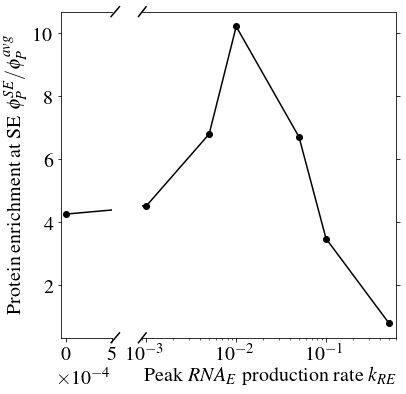

In [234]:
# Plotting the steady state protein recruitment to SE locus

k_p_list = [0.0, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5]
fractions = [data[x]['fold'] for x in k_p_list]

fig,(ax1,ax2) = plt.subplots(1,2,sharey=True,figsize=(6,6), gridspec_kw={'width_ratios': [1, 5]})
ax1.plot(k_p_list, fractions, '-ko')
ax2.plot(k_p_list, fractions, '-ko')

ax1.set_xlim([-5e-5,5e-4])
ax2.set_xlim([9e-4,0.6])

ax1.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax1.yaxis.tick_left()
ax1.tick_params(labelright='off')
ax2.yaxis.tick_right()

ax2.set_xlabel('Peak $RNA_E$ production rate $k_{RE}$')
ax1.set_ylabel('Protein enrichment at SE $\phi^{SE}_P/\phi^{avg}_P$')
ax1.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
ax2.set_xscale('log')

d = .015 # how big to make the diagonal lines in axes coordinates
# arguments to pass plot, just so we don't keep repeating them
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((1-d,1+10*d), (-d,+d), **kwargs)
ax1.plot((1-d,1+10*d),(1-d,1+d), **kwargs)

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d,+d), (1-d,1+d), **kwargs)
ax2.plot((-d,+d), (-d,+d), **kwargs)
plt.savefig('20220223 - Figures for paper/protein_recruitment_to_SE_vs_k_p.svg', format='svg', dpi=600)
# plt.savefig('20220223 - Figures for paper/protein_recruitment_to_SE_vs_phi_p_phi_r_pt005.svg', format='svg', dpi=600)

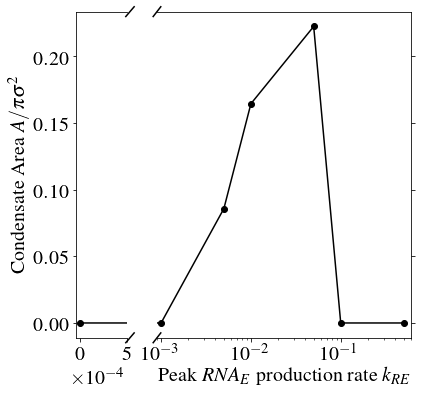

In [235]:
# Plotting the steady state protein recruitment to SE locus

sigma = 5.0

k_p_list = [0.0, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5]
area = [data[x]['condensate_area'] for x in k_p_list]

fig,(ax1,ax2) = plt.subplots(1,2,sharey=True,figsize=(6,6), gridspec_kw={'width_ratios': [1, 5]})
ax1.plot(k_p_list, np.array(area)/(np.pi*sigma**2), '-ko')
ax2.plot(k_p_list, np.array(area)/(np.pi*sigma**2), '-ko')

ax1.set_xlim([-5e-5,5e-4])
ax2.set_xlim([9e-4,0.6])

ax1.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax1.yaxis.tick_left()
ax1.tick_params(labelright='off')
ax2.yaxis.tick_right()

ax2.set_xlabel('Peak $RNA_E$ production rate $k_{RE}$')
ax1.set_ylabel('Condensate Area $A/\pi\sigma^2$')
ax1.ticklabel_format(style='sci', axis='x',scilimits=(-1,0))
ax2.set_xscale('log')

d = .015 # how big to make the diagonal lines in axes coordinates
# arguments to pass plot, just so we don't keep repeating them
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((1-d,1+10*d), (-d,+d), **kwargs)
ax1.plot((1-d,1+10*d),(1-d,1+d), **kwargs)

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d,+d), (1-d,1+d), **kwargs)
ax2.plot((-d,+d), (-d,+d), **kwargs)
plt.savefig('20220223 - Figures for paper/Condensate_area_vs_k_p.svg', format='svg', dpi=600)
# plt.savefig('20220223 - Figures for paper/protein_recruitment_to_SE_vs_phi_p_phi_r_pt005.svg', format='svg', dpi=600)

### Steady state concentration profiles

NameError: name 'mesh' is not defined

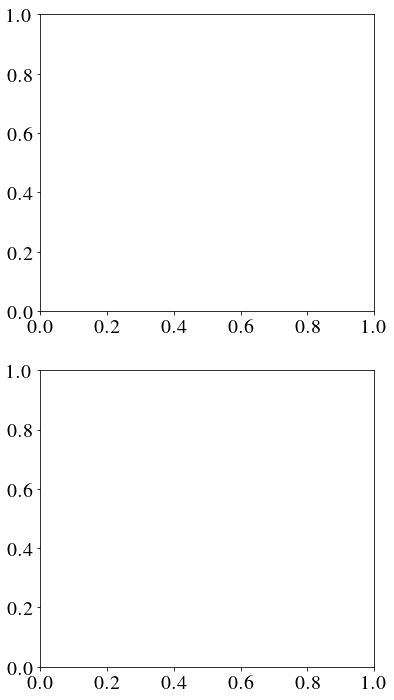

In [70]:
# Plotting the protein and lncRNA concentration profiles for phi_p = 0.04, phi_r = 0.001

delta = 0.2
sigma = 5.0
phi_p = 0.04

k_p_list = [0.0, 0.005, 0.01, 0.05, 0.1, 0.5]

#### One way to normalize phi_m
# k_deg = 0.02
# factor_for_average_rate = 0.95
# phi_m_bar = np.array(k_p_list)*factor_for_average_rate/k_deg

### Another way to normalize phi_m
chi_pm = 1.2
rho_m = 2.0
phi_m_bar = [chi_pm*0.3/rho_m]*len(k_p_list) 

fig,axs = plt.subplots(2,1,figsize=(6,12))
indices_without_well = [(mesh.y < delta) * (mesh.y > -delta) * (mesh.x < 12.0) * (mesh.x > -12.0)]

cmap_p = plt.get_cmap('Blues')
cmap_m = plt.get_cmap('Reds')
color_vals = np.linspace(0.3,1.0,len(k_p_list))

for i in range(len(k_p_list)):
    axs[0].scatter((np.array(mesh.x[indices_without_well]))/sigma,
                    np.array(data[k_p_list[i]]['phi_p'][indices_without_well])/phi_p, 
                    label="$k_{RE}=$"+str(k_p_list[i]), s=15, alpha=0.5, c=cmap_p(color_vals[i]))
    axs[1].scatter((np.array(mesh.x[indices_without_well]))/sigma,
                    np.array(data[k_p_list[i]]['phi_m'][indices_without_well])/phi_m_bar[i], 
                    label="$k_{RE}=$"+str(k_p_list[i]), s=15, alpha=0.5, c=cmap_m(color_vals[i]))

axs[0].set_ylabel(r'Protein vol. frac. $\phi_P(r)/\phi^{avg}_P$')
axs[0].legend(bbox_to_anchor=(1, 1), loc='left', ncol=1)
axs[0].set_xlim([-2.5,2.5])

axs[1].set_ylabel(r'$RNA_E$ vol. frac. $\phi_{RE}(r)/\phi^{c}_R$')
axs[1].legend(bbox_to_anchor=(1, 1), loc='left', ncol=1)
axs[1].set_xlim([-2.5,2.5])
axs[1].set_xlabel('Radial position $L/\sigma$')
plt.savefig('20220223 - Figures for paper/1d_concentration_profile_vs_kp.svg', format='svg')

In [ ]:
# Plotting the protein and lncRNA concentration profiles for phi_p = 0.04, phi_r = 0.001

delta = 0.2
sigma = 5.0
phi_p = 0.04

k_p_list = [0.0, 0.001, 0.005, 0.01, 0.05, 0.1]

#### One way to normalize phi_m
# k_deg = 0.02
# factor_for_average_rate = 0.95
# phi_m_bar = np.array(k_p_list)*factor_for_average_rate/k_deg

### Another way to normalize phi_m
chi_pm = 1.2
rho_m = 2.0
phi_m_bar = [chi_pm*0.3/rho_m]*len(k_p_list) 

min_rna_val = 0.0/phi_m_bar[0]
max_rna_val = 0.45/phi_m_bar[0]

min_protein_val = 0.0/phi_p
max_protein_val = 0.45/phi_p

indices_without_well = [(mesh.y < delta) * (mesh.y > -delta) * (mesh.x < 12.0) * (mesh.x > -12.0)]
cmap_p = plt.get_cmap('Blues')
cmap_m = plt.get_cmap('Reds')

for i in range(len(k_p_list)):
    fig,axs = plt.subplots(1,2,figsize=(12,6))
    cs1 = axs[0].tricontourf(mesh.x/sigma, mesh.y/sigma, data[k_p_list[i]]['phi_p'].value/phi_p,
                   levels=np.linspace(min_protein_val,max_protein_val,256), cmap='Blues')
    cs2 = axs[1].tricontourf(mesh.x/sigma, mesh.y/sigma, data[k_p_list[i]]['phi_m'].value/phi_m_bar[i],
                   levels=np.linspace(min_rna_val,max_rna_val,256), cmap='Reds')
    cbar1 = fig.colorbar(cs1, ax=axs[0], ticks=np.linspace(min_protein_val,max_protein_val,6))
    cbar2 = fig.colorbar(cs2, ax=axs[1], ticks=np.linspace(min_rna_val,max_rna_val,6))
    axs[0].set_title(r'Protein vol. frac. $\phi_P/\phi^{avg}_P$',fontsize=20)
    axs[1].set_title(r'mRNA vol. frac. $\phi_M/\phi^{c}_M$',fontsize=20)
    plt.savefig('20220223 - Figures for paper/2d_concentration_profile_{kp}_kp.svg'.format(kp=k_p_list[i]), format='svg')   

In [7]:
k_p_list = [0.0, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5]

# no lncRNA
target_directory = '/nfs/arupclab001/npradeep96/PhaseField/ACTIVE_MRNA_LNCRNA/MODIFIED_FH_NO_PHIP_COUPLING_VARY_kp_kl/'
name_pattern = "phi_p0_0.04_k_p_lncRNA_0.0_.*_k_p_{p}_.*_Mmrna_0.1_.*_c_max_0.2_phi_r_00.0$"
mesh, data = get_protein_concentration_profiles(param_list=k_p_list,  
                                                target_directory=target_directory, time_step=-1,
                                                name_pattern=name_pattern, nx=300, dx=0.1, sigma=5.0, 
                                                L_P=[0.0]*len(k_p_list))

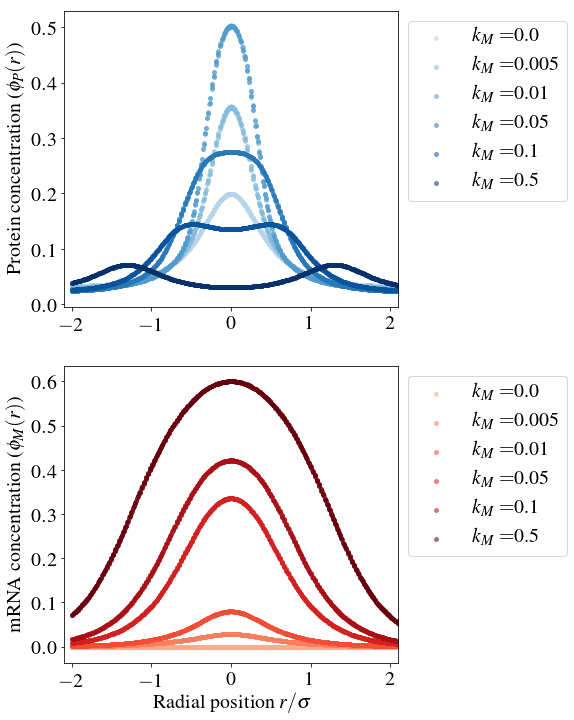

In [96]:
# Plotting the protein and lncRNA concentration profiles for phi_p = 0.04, phi_r = 0.001

delta = 0.2
sigma = 5.0
phi_p = 0.04
L_P = 4.0

k_p_list = [0.0, 0.005, 0.01, 0.05, 0.1, 0.5]

#### One way to normalize phi_m
# k_deg = 0.02
# factor_for_average_rate = 0.95
# phi_m_bar = np.array(k_p_list)*factor_for_average_rate/k_deg

### Another way to normalize phi_m
chi_pm = 1.2
rho_m = 2.0
phi_m_bar = [chi_pm*0.3/rho_m]*len(k_p_list) 

fig,axs = plt.subplots(2,1,figsize=(6,12))
indices_without_well = [(mesh.y < delta) * (mesh.y > -delta) * (mesh.x < 12.0) * (mesh.x > -12.0)]

cmap_p = plt.get_cmap('Blues')
cmap_m = plt.get_cmap('Reds')
color_vals = np.linspace(0.3,1.0,len(k_p_list))

for i in range(len(k_p_list)):
    axs[0].scatter((np.array(mesh.x[indices_without_well]+0.5*L_P))/sigma,
                    np.array(data[k_p_list[i]]['phi_p'][indices_without_well]), 
                    label="$k_{M}=$"+str(k_p_list[i]), s=15, alpha=0.5, c=cmap_p(color_vals[i]))
    axs[1].scatter((np.array(mesh.x[indices_without_well]+0.5*L_P))/sigma,
                    np.array(data[k_p_list[i]]['phi_m'][indices_without_well]), 
                    label="$k_{M}=$"+str(k_p_list[i]), s=15, alpha=0.5, c=cmap_m(color_vals[i]))

axs[0].set_ylabel(r'Protein concentration ($\phi_P(r)$)')
axs[0].legend(bbox_to_anchor=(1, 1), loc='left', ncol=1)
axs[0].set_xlim([-2.1,2.1])

axs[1].set_ylabel(r'mRNA concentration ($\phi_{M}(r)$)')
axs[1].legend(bbox_to_anchor=(1, 1), loc='left', ncol=1)
axs[1].set_xlim([-2.1,2.1])
axs[1].set_xlabel('Radial position $r/\sigma$')
plt.savefig('20220223 - Figures for paper/1d_concentration_profile_vs_kp.svg', format='svg')

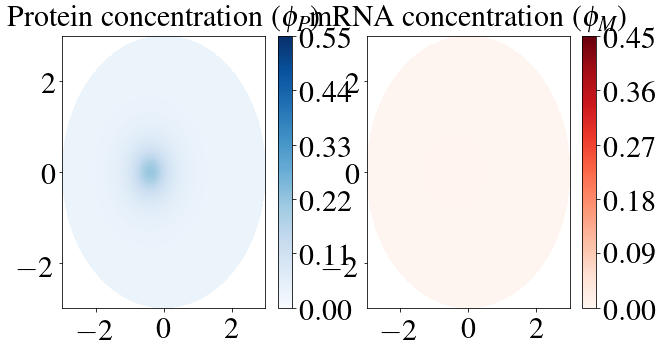

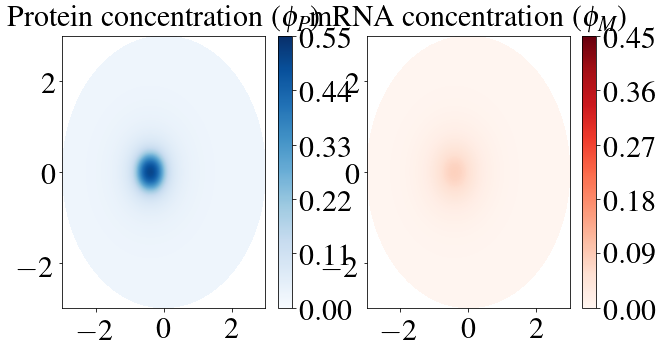

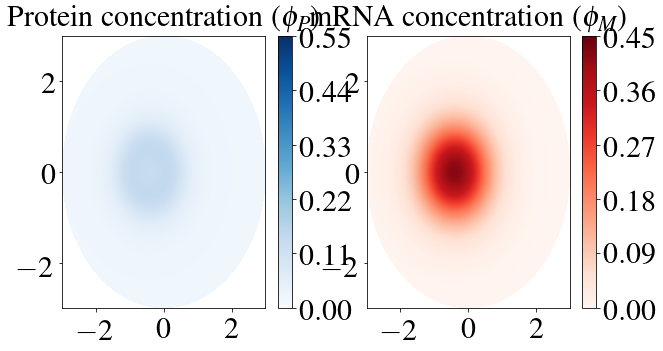

In [85]:
# Plotting the protein and lncRNA concentration profiles for phi_p = 0.04, phi_r = 0.001

delta = 0.2
sigma = 5.0
phi_p = 0.04

k_p_list = [0.001, 0.01, 0.1]

#### One way to normalize phi_m
# k_deg = 0.02
# factor_for_average_rate = 0.95
# phi_m_bar = np.array(k_p_list)*factor_for_average_rate/k_deg

### Another way to normalize phi_m
chi_pm = 1.2
rho_m = 2.0
phi_m_bar = [chi_pm*0.3/rho_m]*len(k_p_list) 

min_rna_val = 0.0
max_rna_val = 0.45

min_protein_val = 0.0
max_protein_val = 0.55

indices_without_well = [(mesh.y < delta) * (mesh.y > -delta) * (mesh.x < 12.0) * (mesh.x > -12.0)]
cmap_p = plt.get_cmap('Blues')
cmap_m = plt.get_cmap('Reds')

for i in range(len(k_p_list)):
    fig,axs = plt.subplots(1,2,figsize=(10,5))
    cs1 = axs[0].tricontourf(mesh.x/sigma, mesh.y/sigma, data[k_p_list[i]]['phi_p'].value,
                   levels=np.linspace(min_protein_val,max_protein_val,256), cmap='Blues')
    cs2 = axs[1].tricontourf(mesh.x/sigma, mesh.y/sigma, data[k_p_list[i]]['phi_m'].value,
                   levels=np.linspace(min_rna_val,max_rna_val,256), cmap='Reds')
    axs[0].tick_params(axis='both', which='major', labelsize=30)
    axs[1].tick_params(axis='both', which='major', labelsize=30)
    cbar1 = fig.colorbar(cs1, ax=axs[0], ticks=np.linspace(min_protein_val,max_protein_val,6))
    cbar2 = fig.colorbar(cs2, ax=axs[1], ticks=np.linspace(min_rna_val,max_rna_val,6))
    cbar1.ax.tick_params(labelsize=30)
    cbar2.ax.tick_params(labelsize=30)
    axs[0].xaxis.set_ticks(np.arange(-2.0, 2.1, 2.0))
    axs[0].yaxis.set_ticks(np.arange(-2.0, 2.1, 2.0))
    axs[1].xaxis.set_ticks(np.arange(-2.0, 2.1, 2.0))
    axs[1].yaxis.set_ticks(np.arange(-2.0, 2.1, 2.0))
    axs[0].set_title(r'Protein concentration ($\phi_P$)',fontsize=30)
    axs[1].set_title(r'mRNA concentration ($\phi_M$)',fontsize=30)
    plt.savefig('20220223 - Figures for paper/2d_concentration_profile_{kp}_kp.svg'.format(kp=k_p_list[i]), format='svg')   

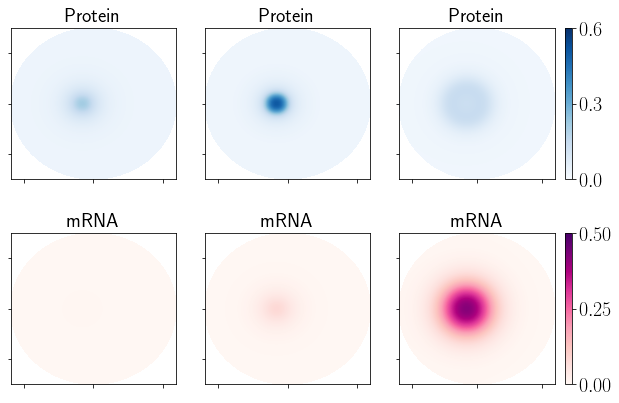

In [31]:
# Plotting the protein and lncRNA concentration profiles for phi_p = 0.04, phi_r = 0.001

delta = 0.2
sigma = 5.0
phi_p = 0.04

k_p_list = [0.001, 0.01, 0.1]

#### One way to normalize phi_m
# k_deg = 0.02
# factor_for_average_rate = 0.95
# phi_m_bar = np.array(k_p_list)*factor_for_average_rate/k_deg

### Another way to normalize phi_m
chi_pm = 1.2
rho_m = 2.0
phi_m_bar = [chi_pm*0.3/rho_m]*len(k_p_list) 

min_rna_val = 0.0
max_rna_val = 0.5

min_protein_val = 0.0
max_protein_val = 0.6

indices_without_well = [(mesh.y < delta) * (mesh.y > -delta) * (mesh.x < 12.0) * (mesh.x > -12.0)]
cmap_p = plt.get_cmap('Blues')
cmap_m = plt.get_cmap('RdPu')

fig,axs = plt.subplots(2,3,figsize=(9,6), gridspec_kw={'width_ratios': [0.85, 0.85, 1]})

for i in range(len(k_p_list)):
    cs1 = axs[0,i].tricontourf(mesh.x/sigma, mesh.y/sigma, data[k_p_list[i]]['phi_p'].value,
                   levels=np.linspace(min_protein_val,max_protein_val,256), cmap='Blues')
    cs2 = axs[1,i].tricontourf(mesh.x/sigma, mesh.y/sigma, data[k_p_list[i]]['phi_m'].value,
                   levels=np.linspace(min_rna_val,max_rna_val,256), cmap='RdPu')
    axs[0,i].set_title(r'Protein',fontsize=20)
    axs[1,i].set_title(r'mRNA',fontsize=20)
    axs[0,i].axes.xaxis.set_ticklabels([])
    axs[0,i].axes.yaxis.set_ticklabels([])
    axs[1,i].axes.xaxis.set_ticklabels([])
    axs[1,i].axes.yaxis.set_ticklabels([])

fig.subplots_adjust(right=0.9)
# cbar_ax_1 = fig.add_axes([0.95, 0.55, 0.01, 0.3])
cbar_1 = fig.colorbar(cs1, ax=axs[0,i])
# cbar_ax_2 = fig.add_axes([0.95, 0.1, 0.01, 0.3])
cbar_2 = fig.colorbar(cs2, ax=axs[1,i])
cbar_1.set_ticks(np.linspace(min_protein_val,max_protein_val,3))
cbar_2.set_ticks(np.linspace(min_rna_val,max_rna_val,3)) 
fig.tight_layout()
# plt.savefig('20220223 - Figures for paper/2d_concentration_profile_{kp}_kp.svg'.format(kp=k_p_list[i]), format='svg')   
plt.savefig('20220223 - Figures for paper/2d_concentration_profile_{kp}_kp.png'.format(kp=k_p_list[i]), format='png')   
# plt.savefig('20220223 - Figures for paper/2d_concentration_profile_{kp}_kp.pdf'.format(kp=k_p_list[i]), format='pdf')   

### Dynamics: gene expression dynamics, protein recruitment dynamics to the enhancer, and total amount of mRNA produced

In [21]:
def generate_dynamical_trajectories(param_list, target_directory, name_pattern, nx=300, dx=0.1,
                                    stats_file = 'stats.txt', dynamical_trajectory_file_name='dynamical_trajectories.hdf5',
                                    spatial_variables_file='spatial_variables.hdf5', 
                                    param_file='input_params.txt', phi_p_thresh=0.22):
    """
    Function to run through directories with simulations for different values of parameters in param_list and calculate 
    different dynamical variables as a function of time for the dynamical variables described int he below list.
    The trajectories are stored as a hdf5 file which is name "dynamical_trajectories.hdf5"
    """
    
    dynamical_variables = ['protein_in_SE', 'fold_protein_in_SE', 'erna_in_SE', 'fold_erna_in_SE', 
                           'lncrna_in_SE', 'fold_lncrna_in_SE', 'total_lncRNA', 'avg_lncRNA', 'fold_avg_lncRNA',
                           'condensate_area', 
                           'total_eRNA', 'avg_eRNA', 'fold_avg_eRNA', 'eRNA_production_rate', 'avg_eRNA_production_rate',
                           'non_dim_avg_eRNA_production_rate', 'eRNA_net_rate', 'avg_eRNA_net_rate', 
                           'non_dim_avg_eRNA_net_rate', 'rate_of_PolII_loading', 
                           'non_dim_rate_of_PolII_loading', 'cumulative_PolII_loaded', 'non_dim_cumulative_PolII_loaded']  
    
    for i in range(len(param_list)):

        pattern = name_pattern.format(p=param_list[i])

        for root, dirs, files in os.walk(target_directory):

            regex = re.compile(pattern)
            match = re.search(regex, root)

            if match != None:
                
                # Read stats file to get times and step numbers
                stats_file_name = root + '/' + stats_file
                df_stats = pd.read_csv(stats_file_name, '\t')
                times = df_stats['t']
                steps = df_stats['step']
                
                input_param_file = root + '/' + param_file
                input_parameters = lh.input_parse(input_param_file)
                if input_parameters['nx'] != nx or input_parameters['dx'] != dx:
                    nx = input_parameters['nx']
                    dx = input_parameters['dx']
                
                # Create mesh
                mesh = lh.create_circular_mesh(radius=float(nx)*dx/2,cellSize=dx*1.5)
                spatial_variable_hdf5_file_name = root + '/' + spatial_variables_file
                
                # Create kernels
                k_p_x = (input_parameters['k_p_max']*
                         fp.CellVariable(mesh=mesh, value=np.exp(-((mesh.cellCenters[0]+0.5*input_parameters['rna_nucleus_distance_to_protein'])**2 + (mesh.cellCenters[1])**2)
                                                                 /input_parameters['spread_kp']**2)))
                kp_bar = np.sum(k_p_x.value*mesh.cellVolumes)/np.sum(mesh.cellVolumes)
                gene_expression_kernel = fp.CellVariable(mesh=mesh, value=np.exp(-((mesh.cellCenters[0]+0.5*input_parameters['rna_nucleus_distance_to_protein'])**2 
                                                                                + (mesh.cellCenters[1])**2)
                                                                                 /((0.1*input_parameters['spread_kp']**2))))
                
                # Creat a HDF5 file to store dynamical trajectories
                with h5py.File(os.path.join(root + '/' + dynamical_trajectory_file_name), 'w') as dt_f:
                    for dv in dynamical_variables:
                        dt_f.create_dataset(dv, shape=(len(steps),1))
                
                # Read through the spatial concentration profiles vs. time to generate trajectories for dynamical variables
                with h5py.File(spatial_variable_hdf5_file_name) as sp_f:
                    with h5py.File(os.path.join(root + '/' + dynamical_trajectory_file_name), 'a') as dt_f:
                        kp_spread = input_parameters['spread_kp']
                        indices_enhancer = (mesh.x+0.5*input_parameters['rna_nucleus_distance_to_protein'])**2 + mesh.y**2 < 0.5*input_parameters['sigma']**2
                        
                        dt_f['cumulative_PolII_loaded'][0] = 0.0
                        dt_f['non_dim_cumulative_PolII_loaded'][0] = 0.0
                        
                        for s in range(len(times)):
                            phi_p = fp.CellVariable(mesh=mesh, value = sp_f['phi_p'][s])
                            phi_m = fp.CellVariable(mesh=mesh, value = sp_f['phi_m'][s])
                            phi_r = fp.CellVariable(mesh=mesh, value = sp_f['phi_r'][s])
                            phi_avg = np.sum(phi_p.value*mesh.cellVolumes)/np.sum(mesh.cellVolumes)
                            
                            dt_f['protein_in_SE'][s] = (np.sum(phi_p.value[indices_enhancer]
                                                                    *mesh.cellVolumes[indices_enhancer])
                                                              /(np.sum(mesh.cellVolumes[indices_enhancer])))
                            dt_f['fold_protein_in_SE'][s] = dt_f['protein_in_SE'][s]/phi_avg
                            chi_pm = input_parameters['chi_m']
                            rho_m = input_parameters['rho_r']
                            phi_m_bar = chi_pm*0.3/rho_m
                            dt_f['erna_in_SE'][s] = (np.sum(phi_m.value[indices_enhancer]
                                                                    *mesh.cellVolumes[indices_enhancer])
                                                              /(np.sum(mesh.cellVolumes[indices_enhancer])))
                            dt_f['fold_erna_in_SE'][s] = dt_f['erna_in_SE'][s]/phi_m_bar
                            
                            dt_f['lncrna_in_SE'][s] = (np.sum(phi_r.value[indices_enhancer]
                                                                    *mesh.cellVolumes[indices_enhancer])
                                                              /(np.sum(mesh.cellVolumes[indices_enhancer])))
                            dt_f['fold_lncrna_in_SE'][s] = dt_f['lncrna_in_SE'][s]/phi_m_bar
                            
                            condensate_indices = phi_p > phi_p_thresh
                            dt_f['condensate_area'][s] = (np.sum(mesh.cellVolumes[condensate_indices])
                                                          /(np.pi*input_parameters['sigma']**2))
                            
                            dt_f['total_eRNA'][s] = np.sum(phi_m.value*mesh.cellVolumes)
                            dt_f['avg_eRNA'][s] = dt_f['total_eRNA'][s]/np.sum(mesh.cellVolumes)
                            dt_f['fold_avg_eRNA'][s] = dt_f['avg_eRNA'][s]/phi_m_bar
                            
                            dt_f['total_lncRNA'][s] = np.sum(phi_r.value*mesh.cellVolumes)
                            dt_f['avg_lncRNA'][s] = dt_f['total_lncRNA'][s]/np.sum(mesh.cellVolumes)
                            dt_f['fold_avg_lncRNA'][s] = dt_f['avg_lncRNA'][s]/phi_m_bar
                            
                            dt_f['eRNA_production_rate'][s] = np.sum(k_p_x.value[indices_enhancer]*phi_p.value[indices_enhancer]*mesh.cellVolumes[indices_enhancer])
                            dt_f['avg_eRNA_production_rate'][s] = dt_f['eRNA_production_rate'][s]/np.sum(mesh.cellVolumes[indices_enhancer])
                            dt_f['non_dim_avg_eRNA_production_rate'][s] = (dt_f['avg_eRNA_production_rate'][s]/
                                                                           (input_parameters['k_degradation']*phi_m_bar))
                            
                            dt_f['eRNA_net_rate'][s] = (dt_f['eRNA_production_rate'][s] 
                                                        - np.sum(input_parameters['k_degradation']
                                                                 *phi_m.value[indices_enhancer]*mesh.cellVolumes[indices_enhancer]))
                            dt_f['avg_eRNA_net_rate'][s] = dt_f['eRNA_net_rate'][s]/np.sum(mesh.cellVolumes[indices_enhancer])
                            dt_f['non_dim_avg_eRNA_net_rate'][s] = (dt_f['avg_eRNA_net_rate'][s]/
                                                                           (input_parameters['k_degradation']*phi_m_bar))
                            
                            dt_f['rate_of_PolII_loading'][s] = np.sum(gene_expression_kernel.value*phi_p.value
                                                                      *mesh.cellVolumes)
                            # dt_f['avg_rate_of_PolII_loading'][s] = dt_f['rate_of_PolII_loading'][s]/np.sum(mesh.cellVolumes)
                            dt_f['non_dim_rate_of_PolII_loading'][s] = (dt_f['rate_of_PolII_loading'][s]
                                                                        /((0.1*np.pi*input_parameters['sigma']**2)*phi_avg))
                            
                            if times[s] != 0.0:
                                dt_f['cumulative_PolII_loaded'][s] = (dt_f['cumulative_PolII_loaded'][s-1] 
                                                                      + dt_f['rate_of_PolII_loading'][s]
                                                                      *(times[s]-times[s-1]))
                                dt_f['non_dim_cumulative_PolII_loaded'][s] = (dt_f['non_dim_cumulative_PolII_loaded'][s-1]
                                                                              + dt_f['non_dim_rate_of_PolII_loading'][s]
                                                                              *input_parameters['k_degradation']
                                                                              *(times[s]-times[s-1]))
                            
                                
                
                print("Succesfully wrote data to " + os.path.join(root + '/' + dynamical_trajectory_file_name) + " ...")

In [23]:
k_p_list = [0.0, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5]

target_directory = '/nfs/arupclab001/npradeep96/PhaseField/ONLY_MRNA_ACTIVITY/MODIFIED_FH/WITH_PROTEIN_WELL/'
name_pattern = "phi_p0_0.04_.*_k_p_{p}_.*_Mmrna_0.1_.*_c_max_0.2_phi_r_00.0$"
generate_dynamical_trajectories(param_list=k_p_list,  
                                target_directory=target_directory, 
                                name_pattern=name_pattern, nx=300, dx=0.1)

Succesfully wrote data to /nfs/arupclab001/npradeep96/PhaseField/ONLY_MRNA_ACTIVITY/MODIFIED_FH/WITH_PROTEIN_WELL/phi_p0_0.04_k_p_lncRNA_0.0_L_P_0.0_k_p_0.0_reactiontype_2.0_thresh_0.0_FE_8.0_MP_100.0_Mmrna_0.1_M_rna_100.0_c_max_0.2_phi_r_00.0/dynamical_trajectories.hdf5 ...
Succesfully wrote data to /nfs/arupclab001/npradeep96/PhaseField/ONLY_MRNA_ACTIVITY/MODIFIED_FH/WITH_PROTEIN_WELL/phi_p0_0.04_k_p_lncRNA_0.0_L_P_0.0_k_p_0.001_reactiontype_2.0_thresh_0.0_FE_8.0_MP_100.0_Mmrna_0.1_M_rna_100.0_c_max_0.2_phi_r_00.0/dynamical_trajectories.hdf5 ...
Succesfully wrote data to /nfs/arupclab001/npradeep96/PhaseField/ONLY_MRNA_ACTIVITY/MODIFIED_FH/WITH_PROTEIN_WELL/phi_p0_0.04_k_p_lncRNA_0.0_L_P_0.0_k_p_0.005_reactiontype_2.0_thresh_0.0_FE_8.0_MP_100.0_Mmrna_0.1_M_rna_100.0_c_max_0.2_phi_r_00.0/dynamical_trajectories.hdf5 ...
Succesfully wrote data to /nfs/arupclab001/npradeep96/PhaseField/ONLY_MRNA_ACTIVITY/MODIFIED_FH/WITH_PROTEIN_WELL/phi_p0_0.04_k_p_lncRNA_0.0_L_P_0.0_k_p_0.01_reactionty

In [24]:
k_p_list = [0.0, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5]

target_directory = '/nfs/arupclab001/npradeep96/PhaseField/ACTIVE_MRNA_LNCRNA/MODIFIED_FH_NO_PHIP_COUPLING_VARY_kp_kl/'                    
name_pattern = "phi_p0_0.04_k_p_lncRNA_0.0_.*_k_p_{p}_.*_Mmrna_0.1_.*_c_max_0.2_phi_r_00.0$"

generate_dynamical_trajectories(param_list=k_p_list,  
                                target_directory=target_directory, 
                                name_pattern=name_pattern, nx=300, dx=0.1)

Succesfully wrote data to /nfs/arupclab001/npradeep96/PhaseField/ACTIVE_MRNA_LNCRNA/MODIFIED_FH_NO_PHIP_COUPLING_VARY_kp_kl/phi_p0_0.04_k_p_lncRNA_0.0_L_P_4.0_k_p_0.0_reactiontype_2.0_thresh_0.0_FE_8.0_MP_100.0_Mmrna_0.1_M_rna_0.1_c_max_0.2_phi_r_00.0/dynamical_trajectories.hdf5 ...
Succesfully wrote data to /nfs/arupclab001/npradeep96/PhaseField/ACTIVE_MRNA_LNCRNA/MODIFIED_FH_NO_PHIP_COUPLING_VARY_kp_kl/phi_p0_0.04_k_p_lncRNA_0.0_L_P_4.0_k_p_0.001_reactiontype_2.0_thresh_0.0_FE_8.0_MP_100.0_Mmrna_0.1_M_rna_0.1_c_max_0.2_phi_r_00.0/dynamical_trajectories.hdf5 ...
Succesfully wrote data to /nfs/arupclab001/npradeep96/PhaseField/ACTIVE_MRNA_LNCRNA/MODIFIED_FH_NO_PHIP_COUPLING_VARY_kp_kl/phi_p0_0.04_k_p_lncRNA_0.0_L_P_4.0_k_p_0.005_reactiontype_2.0_thresh_0.0_FE_8.0_MP_100.0_Mmrna_0.1_M_rna_0.1_c_max_0.2_phi_r_00.0/dynamical_trajectories.hdf5 ...
Succesfully wrote data to /nfs/arupclab001/npradeep96/PhaseField/ACTIVE_MRNA_LNCRNA/MODIFIED_FH_NO_PHIP_COUPLING_VARY_kp_kl/phi_p0_0.04_k_p_lncR

In [67]:
def get_dynamical_trajectories(param_list, variable_name, target_directory, name_pattern, 
                                stats_file = 'stats.txt', dynamical_trajectory_file_name='dynamical_trajectories.hdf5',
                                spatial_variables_file='spatial_variables.hdf5'):
    """
    Function to run through directories with simulations for different values of parameters in param_list and get the 
    dynamical trajectory corresponding to "variable_name" in "dynamical_trajectories.hdf5"
    """
    
    trajectories = {}
    
    for i in range(len(param_list)):
        
        # Store the dynamical variable trajectories in a dictionary
        data = {}
        
        pattern = name_pattern.format(p=param_list[i])
        
        for root, dirs, files in os.walk(target_directory):

            regex = re.compile(pattern)
            match = re.search(regex, root)

            if match != None:

                # Read stats file to get times and step numbers
                stats_file_name = root + '/' + stats_file
                df_stats = pd.read_csv(stats_file_name, '\t')
                data['t'] = df_stats['t']
                
                # Read through the dynamical trajectories file to extract the appropriate variable
                with h5py.File(os.path.join(root + '/' + dynamical_trajectory_file_name), 'a') as dt_f:        
                    data[variable_name] = dt_f[variable_name][:,0]
        
        trajectories[param_list[i]] = data
     
    return trajectories

In [68]:
def get_list_of_trajectories(param_list, target_directory_list, name_pattern_list, variable_name):
    
    """
    Function to get a list of dynamical trajectories for a desired dynamical variables, each trajectory 
    derived from a folder in target_directory_list 
    """
    
    trajectories = list()
    for i in range(len(target_directory_list)):
        trajectories.append(get_dynamical_trajectories(param_list=param_list, variable_name=variable_name,
                                                       target_directory=target_directory_list[i],
                                                       name_pattern=name_pattern_list[i]))
    return trajectories

## Plots of dynamics

/home/npradeep96/miniconda3/envs/fipyenv/lib/python2.7/site-packages/matplotlib/legend.py:640: UserWarning: Unrecognized location "left". Falling back on "best"; valid locations are
	right
	center left
	upper right
	lower right
	best
	center
	lower left
	center right
	upper left
	upper center
	lower center

  % (loc, '\n\t'.join(self.codes)))
/home/npradeep96/miniconda3/envs/fipyenv/lib/python2.7/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (83) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/times/utmri8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/npradeep96/miniconda3/envs/fipyenv/lib/python2.7/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (69) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/times/utmri8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/npradeep96/miniconda3/envs/fipyenv/lib/python

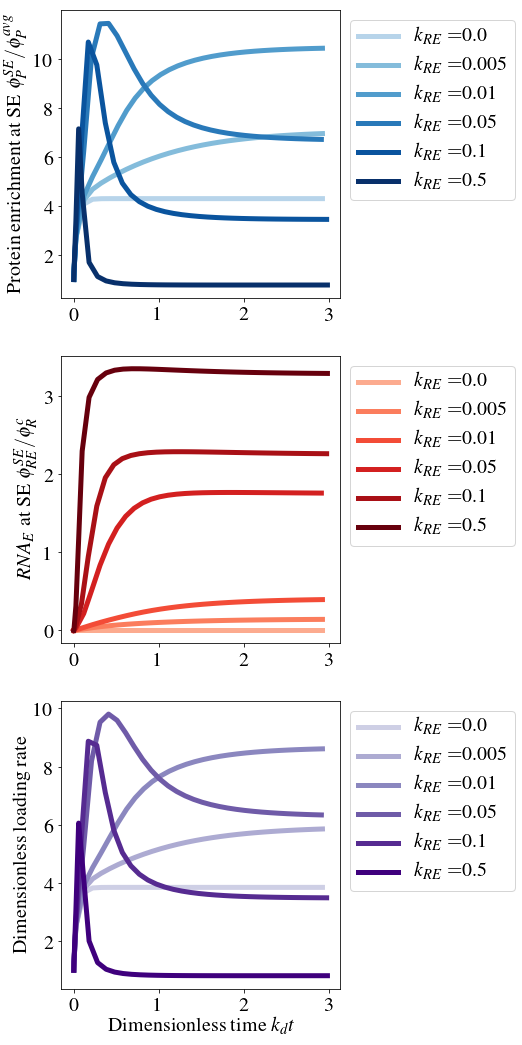

In [25]:
k_p_list = [0.0, 0.005, 0.01, 0.05, 0.1, 0.5]
k_degradation = 0.02

target_directory_list = ['/nfs/arupclab001/npradeep96/PhaseField/ONLY_MRNA_ACTIVITY/MODIFIED_FH/WITH_PROTEIN_WELL/']                    
name_pattern_list = ["phi_p0_0.04_.*_k_p_{p}_.*_Mmrna_0.1_.*_c_max_0.2_phi_r_00.0$"]

variable_names = ['fold_protein_in_SE', 'fold_erna_in_SE', 
                  'non_dim_rate_of_PolII_loading']
# ylabels = ['Protein enrichment at SE $\phi^{SE}_P/\phi^{avg}_P$',
#            '$RNA_E$ at SE $\phi^{SE}_R/\phi^c_R$', 'Condensate Area $A/\pi\sigma^2$', 
#            'RNA vol. frac. in system $\phi^{avg}_R/\phi^c_R$', 
#            'RNA production rate $\int k_p(r)\phi_p(r)dV/(k_d\phi^c_R)$',
#            'net rate of RNA $\uparrow ~ 1/(k_d\phi^c_R)\partial \phi^{avg}_R/\partial t$',
#            'Rate of Pol II loading $1/(k_d\phi_RV)\int G(r)\phi_p(r)dV$', 
#            'Total Pol II loaded $1/(\phi^{avg}_PV)\int\int G(r)\phi_p(r)dVdt$']

ylabels = ['Protein concentration at PCG locus $\phi^{PCG}_P$',
           'mRNA concentration at PCG locus $\phi^{PCG}_{M}$', 
           'Dimensionless loading rate']
cmaps = ['Blues', 'Reds', 'Purples']
# cmaps = ['Blues', 'Reds', 'Blues', 'Reds', 'Reds', 'Reds', 'Purples', 'Purples']
N = len(variable_names)

fig, axs = plt.subplots(N,1,figsize=(5,6*N))
color_vals = np.linspace(0.3,1.0,len(k_p_list))

for j in range(len(variable_names)):
    trajectories = get_list_of_trajectories(param_list=k_p_list,
                                            target_directory_list=target_directory_list,
                                            name_pattern_list=name_pattern_list,
                                            variable_name=variable_names[j])
    cmap = plt.get_cmap(cmaps[j])
    for i in range(len(k_p_list)):
        axs[j].plot(k_degradation*trajectories[0][k_p_list[i]]['t'], trajectories[0][k_p_list[i]][variable_names[j]], 
                    '-', c=cmap(color_vals[i]), label="$k_{M}=$"+"{kp}".format(kp=k_p_list[i]),linewidth=5.0)

    axs[j].set_ylabel(ylabels[j])
    # axs[j].set_xlim([-0.1,5.0])
    axs[j].legend(bbox_to_anchor=(1, 1), loc='left', ncol=1)

axs[j].set_xlabel('Dimensionless time $k_dt$')
plt.savefig('20220223 - Figures for paper/dynamics_vs_kp.svg', format='svg', dpi=600)

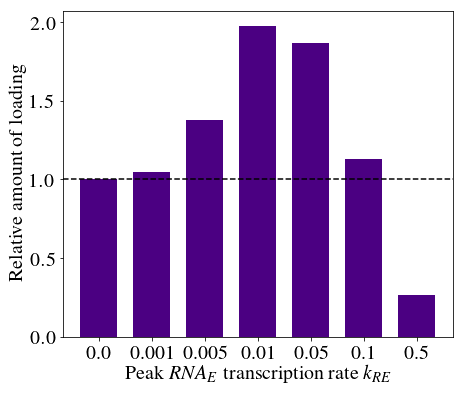

In [302]:
k_p_list = [0.0, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5]
labels = ['0.0', '0.001', '0.005', '0.01', '0.05', '0.1', '0.5']
variable_name = 'non_dim_cumulative_PolII_loaded'
trajectories = get_list_of_trajectories(param_list=k_p_list,
                                        target_directory_list=target_directory_list,
                                        name_pattern_list=name_pattern_list,
                                        variable_name=variable_name)
ratio = [trajectories[0][k_p_list[i]][variable_name][-1]/trajectories[0][0][variable_name][-1] 
         for i in range(len(k_p_list))]

fig, axs = plt.subplots(1,1,figsize=(7,6))
axs.bar(labels, ratio, color='indigo', width=0.7)
axs.set_ylabel('Relative amount of loading')
axs.set_xlabel('Peak $RNA_E$ transcription rate $k_{RE}$')
axs.axhline(y=1.0, color='k', linestyle='--')
plt.savefig('20220223 - Figures for paper/gene_expression_vs_kp_bar.svg', 
            format='svg', dpi=600)

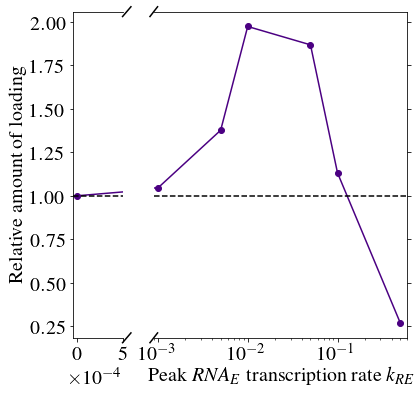

In [330]:
# Plotting the steady state protein recruitment to SE locus

k_p_list = [0.0, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5]
trajectories = get_list_of_trajectories(param_list=k_p_list,
                                        target_directory_list=target_directory_list,
                                        name_pattern_list=name_pattern_list,
                                        variable_name=variable_name)
ratio = [trajectories[0][k_p_list[i]][variable_name][-1]/trajectories[0][0][variable_name][-1] 
         for i in range(len(k_p_list))]

fig,(ax1,ax2) = plt.subplots(1,2,sharey=True,figsize=(6,6), gridspec_kw={'width_ratios': [1, 5]})
ax1.plot(k_p_list, ratio, '-o', c='indigo')
ax2.plot(k_p_list, ratio, '-o', c='indigo')

ax1.set_xlim([-5e-5,5e-4])
ax2.set_xlim([9e-4,0.6])

ax1.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax1.yaxis.tick_left()
ax1.tick_params(labelright='off')
ax2.yaxis.tick_right()

ax1.set_ylabel('Relative amount of loading')
ax2.set_xlabel('Peak $RNA_E$ transcription rate $k_{RE}$')
ax1.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
ax2.set_xscale('log')

d = .015 # how big to make the diagonal lines in axes coordinates
# arguments to pass plot, just so we don't keep repeating them
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((1-d,1+10*d), (-d,+d), **kwargs)
ax1.plot((1-d,1+10*d),(1-d,1+d), **kwargs)

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d,+d), (1-d,1+d), **kwargs)
ax2.plot((-d,+d), (-d,+d), **kwargs)

ax1.axhline(y=1.0, color='k', linestyle='--')
ax2.axhline(y=1.0, color='k', linestyle='--')

plt.savefig('20220223 - Figures for paper/gene_expression_vs_k_p_line.svg', format='svg', dpi=600)
# plt.savefig('20220223 - Figures for paper/protein_recruitment_to_SE_vs_phi_p_phi_r_pt005.svg', format='svg', dpi=600)

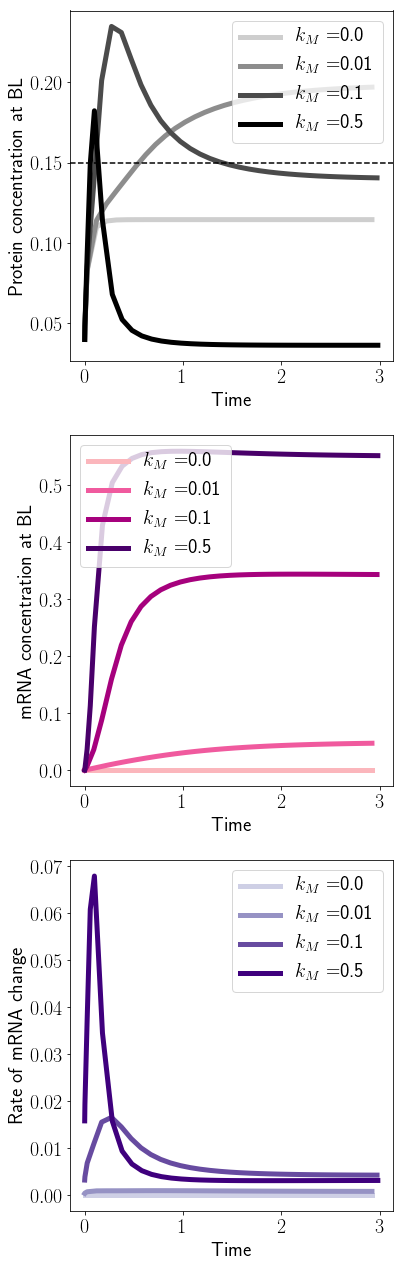

In [100]:
# k_p_list = [0.0, 0.01, 0.05, 0.1, 0.5]
k_p_list = [0.0, 0.01, 0.1, 0.5]
k_degradation = 0.02

target_directory_list = ['/nfs/arupclab001/npradeep96/PhaseField/ACTIVE_MRNA_LNCRNA/MODIFIED_FH_NO_PHIP_COUPLING_VARY_kp_kl/']                    
name_pattern_list = ["phi_p0_0.04_k_p_lncRNA_0.0_.*_k_p_{p}_.*_Mmrna_0.1_.*_c_max_0.2_phi_r_00.0$"]

variable_names = ['protein_in_SE', 'erna_in_SE', 
                  'avg_eRNA_net_rate']
# ylabels = ['Protein enrichment at SE $\phi^{SE}_P/\phi^{avg}_P$',
#            '$RNA_E$ at SE $\phi^{SE}_R/\phi^c_R$', 'Condensate Area $A/\pi\sigma^2$', 
#            'RNA vol. frac. in system $\phi^{avg}_R/\phi^c_R$', 
#            'RNA production rate $\int k_p(r)\phi_p(r)dV/(k_d\phi^c_R)$',
#            'net rate of RNA $\uparrow ~ 1/(k_d\phi^c_R)\partial \phi^{avg}_R/\partial t$',
#            'Rate of Pol II loading $1/(k_d\phi_RV)\int G(r)\phi_p(r)dV$', 
#            'Total Pol II loaded $1/(\phi^{avg}_PV)\int\int G(r)\phi_p(r)dVdt$']

ylabels = ['Protein concentration at BL',
           'mRNA concentration at BL', 
           'Rate of mRNA change']
cmaps = ['Greys', 'RdPu', 'Purples']
# cmaps = ['Blues', 'Reds', 'Blues', 'Reds', 'Reds', 'Reds', 'Purples', 'Purples']
N = len(variable_names)

fig, axs = plt.subplots(N,1,figsize=(6,6*N))
color_vals = np.linspace(0.3,1.0,len(k_p_list))

for j in range(len(variable_names)):
    trajectories = get_list_of_trajectories(param_list=k_p_list,
                                            target_directory_list=target_directory_list,
                                            name_pattern_list=name_pattern_list,
                                            variable_name=variable_names[j])
    cmap = plt.get_cmap(cmaps[j])
    for i in range(len(k_p_list)):
        axs[j].plot(k_degradation*trajectories[0][k_p_list[i]]['t'], trajectories[0][k_p_list[i]][variable_names[j]], 
                    '-', c=cmap(color_vals[i]), label="$k_{M}=$"+"{kp}".format(kp=k_p_list[i]),linewidth=5.0)

    axs[j].set_ylabel(ylabels[j])
    # axs[j].set_xlim([-0.1,5.0])
    # axs[j].legend(bbox_to_anchor=(1, 1), loc='left', ncol=1)
    axs[j].legend()
    axs[j].set_xlabel('Time')

axs[0].axhline(y=0.15, color='k', linestyle='--')
plt.savefig('20220223 - Figures for paper/dynamics_vs_kp.svg', format='svg', dpi=600)

0.0
0.0
2.9209480042
2.9090142084000004
1.2803664650000002
0.041967243200000004


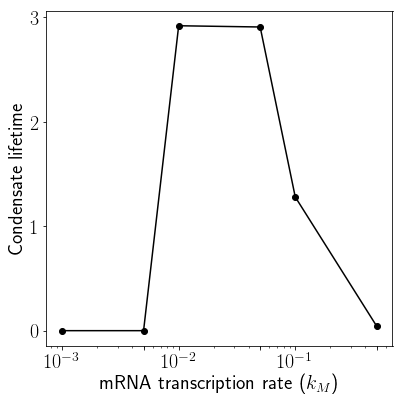

In [66]:
# condensate lifetime

k_p_list = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5]
k_degradation = 0.02
phi_p_thresh = 0.15

target_directory_list = ['/nfs/arupclab001/npradeep96/PhaseField/ACTIVE_MRNA_LNCRNA/MODIFIED_FH_NO_PHIP_COUPLING_VARY_kp_kl/']                    
name_pattern_list = ["phi_p0_0.04_k_p_lncRNA_0.0_.*_k_p_{p}_.*_Mmrna_0.1_.*_c_max_0.2_phi_r_00.0$"]

variable_names = ['protein_in_SE']
# ylabels = ['Protein enrichment at SE $\phi^{SE}_P/\phi^{avg}_P$',
#            '$RNA_E$ at SE $\phi^{SE}_R/\phi^c_R$', 'Condensate Area $A/\pi\sigma^2$', 
#            'RNA vol. frac. in system $\phi^{avg}_R/\phi^c_R$', 
#            'RNA production rate $\int k_p(r)\phi_p(r)dV/(k_d\phi^c_R)$',
#            'net rate of RNA $\uparrow ~ 1/(k_d\phi^c_R)\partial \phi^{avg}_R/\partial t$',
#            'Rate of Pol II loading $1/(k_d\phi_RV)\int G(r)\phi_p(r)dV$', 
#            'Total Pol II loaded $1/(\phi^{avg}_PV)\int\int G(r)\phi_p(r)dVdt$']

times = np.zeros(len(k_p_list))

for j in range(len(variable_names)):
    trajectories = get_list_of_trajectories(param_list=k_p_list,
                                            target_directory_list=target_directory_list,
                                            name_pattern_list=name_pattern_list,
                                            variable_name=variable_names[j])
    for i in range(len(k_p_list)):
        time_range = np.where(trajectories[0][k_p_list[i]][variable_names[j]] > phi_p_thresh)
        # print(trajectories[0][k_p_list[i]]['t'], trajectories[0][k_p_list[i]]['protein_in_SE'])
        if np.any(time_range):
            if np.max(time_range) == np.size(trajectories[0][k_p_list[i]]['t'])-1:
                times[i] = k_degradation*trajectories[0][k_p_list[i]]['t'].iloc[-1]
            else:
                times[i] = k_degradation*trajectories[0][k_p_list[i]]['t'][np.max(time_range)] - k_degradation*trajectories[0][k_p_list[i]]['t'][np.min(time_range)-1]
        print(times[i])

fig, axs = plt.subplots(1,1,figsize=(6,6))
axs.plot(k_p_list, times, '-ko')
axs.set_xlabel('mRNA transcription rate ($k_M$)')
axs.set_ylabel('Condensate lifetime')
axs.set_xscale('log')
axs.xaxis.set_ticks(k_p_list)
axs.yaxis.set_major_locator(MaxNLocator(4))
plt.savefig('20220223 - Figures for paper/condensate_lifetime_vs_kp.svg', format='svg', dpi=600)

/home/npradeep96/miniconda3/envs/fipyenv/lib/python2.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in float_scalars
  # This is added back by InteractiveShellApp.init_path()
/home/npradeep96/miniconda3/envs/fipyenv/lib/python2.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in float_scalars
  # This is added back by InteractiveShellApp.init_path()
/home/npradeep96/miniconda3/envs/fipyenv/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/npradeep96/miniconda3/envs/fipyenv/lib/python2.7/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (107) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/times/utmr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong

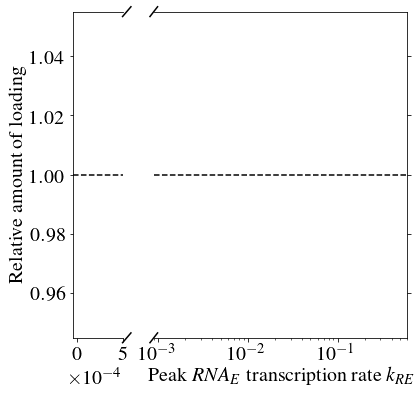

In [93]:
# Plotting the steady state protein recruitment to SE locus

variable_name = 'erna_in_SE'

k_p_list = [0.0, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5]
trajectories = get_list_of_trajectories(param_list=k_p_list,
                                        target_directory_list=target_directory_list,
                                        name_pattern_list=name_pattern_list,
                                        variable_name=variable_name)
ratio = [trajectories[0][k_p_list[i]][variable_name][-1]/trajectories[0][0][variable_name][-1] 
         for i in range(len(k_p_list))]

fig,(ax1,ax2) = plt.subplots(1,2,sharey=True,figsize=(6,6), gridspec_kw={'width_ratios': [1, 5]})
ax1.plot(k_p_list, ratio, '-o', c='indigo')
ax2.plot(k_p_list, ratio, '-o', c='indigo')

ax1.set_xlim([-5e-5,5e-4])
ax2.set_xlim([9e-4,0.6])

ax1.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax1.yaxis.tick_left()
ax1.tick_params(labelright='off')
ax2.yaxis.tick_right()

ax1.set_ylabel('Relative amount of loading')
ax2.set_xlabel('Peak $RNA_E$ transcription rate $k_{RE}$')
ax1.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
ax2.set_xscale('log')

d = .015 # how big to make the diagonal lines in axes coordinates
# arguments to pass plot, just so we don't keep repeating them
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((1-d,1+10*d), (-d,+d), **kwargs)
ax1.plot((1-d,1+10*d),(1-d,1+d), **kwargs)

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d,+d), (1-d,1+d), **kwargs)
ax2.plot((-d,+d), (-d,+d), **kwargs)

ax1.axhline(y=1.0, color='k', linestyle='--')
ax2.axhline(y=1.0, color='k', linestyle='--')

plt.savefig('20220223 - Figures for paper/gene_expression_vs_k_p_line.svg', format='svg', dpi=600)
# plt.savefig('20220223 - Figures for paper/protein_recruitment_to_SE_vs_phi_p_phi_r_pt005.svg', format='svg', dpi=600)

# Effect of nearby RNA on transcription

### Steady state

For kp in the three different regimes, vary kl and plot
1. Steady state mRNA amount, protein at SE and condensate area - 2D plots of phase diagrams. Log scale.
2. Steady state concentration profiles for mRNA, lncRNA and protein

### Concentration profiles

In [31]:
k_pl_list = [0.0, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5]

# no lncRNA
target_directory = '/nfs/arupclab001/npradeep96/PhaseField/ACTIVE_MRNA_LNCRNA/MODIFIED_FH_VARY_kp_kl/'
name_pattern = "phi_p0_0.04_k_p_lncRNA_{p}_.*_k_p_0.01_.*_Mmrna_0.1_.*_c_max_0.2_phi_r_00.0$"
mesh, data = get_protein_concentration_profiles(param_list=k_pl_list,  
                                                target_directory=target_directory, 
                                                name_pattern=name_pattern, time_step=-1, nx=300, dx=0.1, sigma=5.0, 
                                                L_P=[4.0]*len(k_pl_list))

TypeError: get_protein_concentration_profiles() takes at least 8 arguments (7 given)

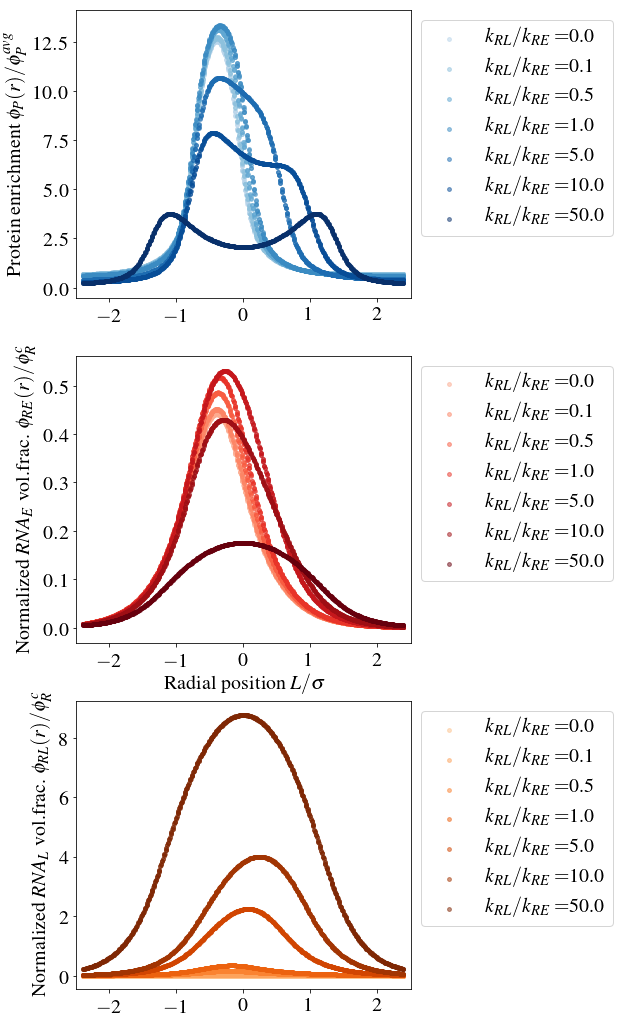

In [262]:
# Plotting the protein and lncRNA concentration profiles for phi_p = 0.04, phi_r = 0.001

delta = 0.2
sigma = 5.0
phi_p = 0.04

kp_base = 0.01
k_pl_list = [0.0, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5]

ratios = np.array(k_pl_list)/kp_base

#### One way to normalize phi_m
# k_deg = 0.02
# factor_for_average_rate = 0.95
# phi_m_bar = np.array(k_p_list)*factor_for_average_rate/k_deg

### Another way to normalize phi_m
chi_pm = 1.2
rho_m = 2.0
phi_m_bar = [chi_pm*0.3/rho_m]*len(k_pl_list) 

fig,axs = plt.subplots(3,1,figsize=(6,18))
indices_without_well = [(mesh.y < delta) * (mesh.y > -delta) * (mesh.x < 12.0) * (mesh.x > -12.0)]

cmap_p = plt.get_cmap('Blues')
cmap_m = plt.get_cmap('Reds')
cmap_l = plt.get_cmap('Oranges')

color_vals = np.linspace(0.3,1.0,len(k_pl_list))

for i in range(len(k_pl_list)):
    axs[0].scatter((np.array(mesh.x[indices_without_well]))/sigma,
                    np.array(data[k_pl_list[i]]['phi_p'][indices_without_well])/phi_p, 
                    label="$k_{RL}/k_{RE}=$"+str(ratios[i]), s=15, alpha=0.5, c=cmap_p(color_vals[i]))
    axs[1].scatter((np.array(mesh.x[indices_without_well]))/sigma,
                    np.array(data[k_pl_list[i]]['phi_m'][indices_without_well])/phi_m_bar[i], 
                    label="$k_{RL}/k_{RE}=$"+str(ratios[i]), s=15, alpha=0.5, c=cmap_m(color_vals[i]))
    axs[2].scatter((np.array(mesh.x[indices_without_well]))/sigma,
                    np.array(data[k_pl_list[i]]['phi_r'][indices_without_well])/phi_m_bar[i], 
                    label="$k_{RL}/k_{RE}=$"+str(ratios[i]), s=15, alpha=0.5, c=cmap_l(color_vals[i]))

axs[0].set_ylabel(r'Protein enrichment $\phi_P(r)/\phi^{avg}_P$')
axs[0].legend(bbox_to_anchor=(1, 1), loc='left', ncol=1)
axs[0].set_xlim([-2.5,2.5])

axs[1].set_ylabel(r'Normalized $RNA_E$ vol.frac. $\phi_{RE}(r)/\phi^{c}_R$')
axs[1].legend(bbox_to_anchor=(1, 1), loc='left', ncol=1)
axs[1].set_xlim([-2.5,2.5])

axs[2].set_ylabel(r'Normalized $RNA_L$ vol.frac. $\phi_{RL}(r)/\phi^{c}_R$')
axs[2].legend(bbox_to_anchor=(1, 1), loc='left', ncol=1)
axs[2].set_xlim([-2.5,2.5])

axs[1].set_xlabel('Radial position $L/\sigma$')

plt.savefig('20220223 - Figures for paper/1d_concentration_profile_vs_kpl.svg', format='svg')

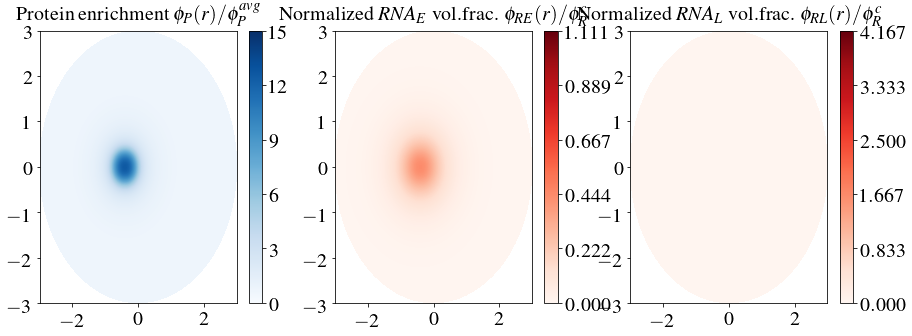

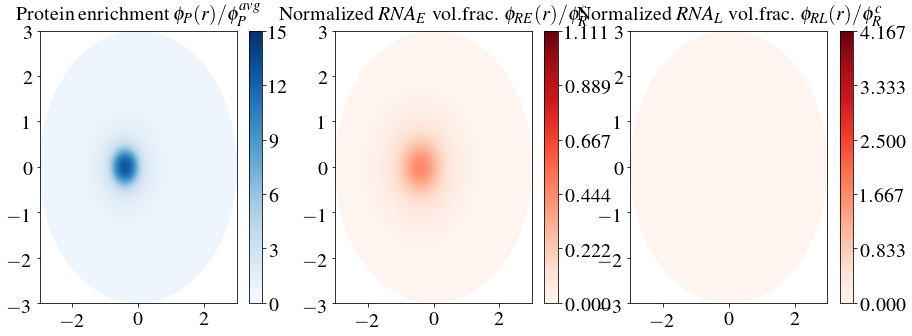

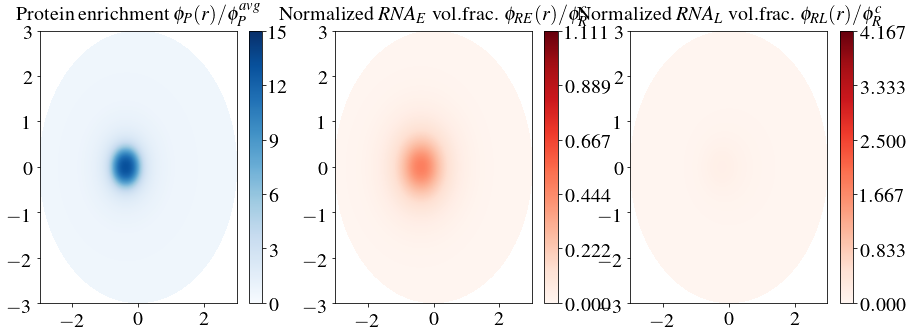

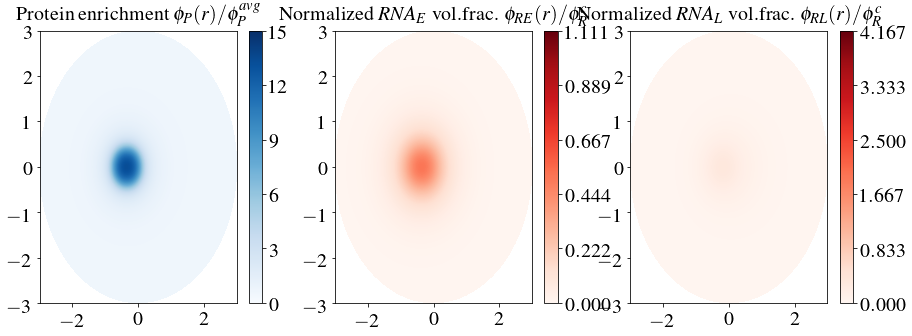

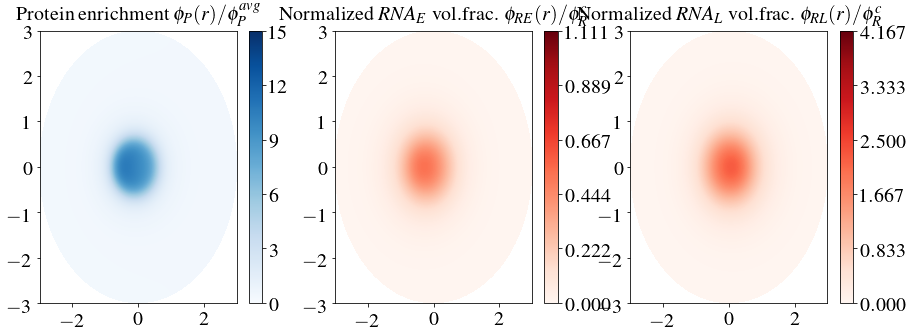

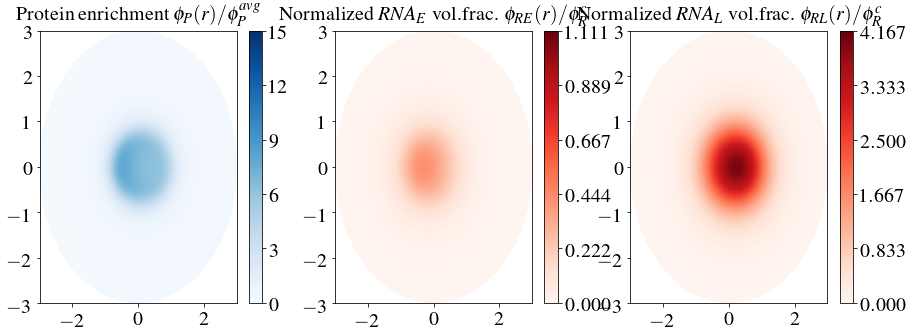

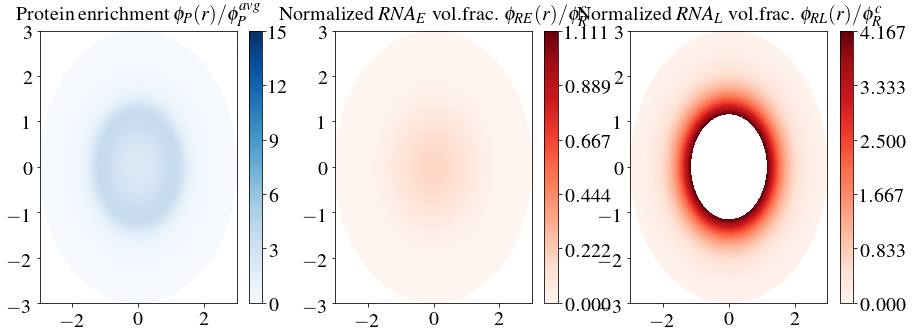

In [260]:
# Plotting the protein and lncRNA concentration profiles for phi_p = 0.04, phi_r = 0.001

delta = 0.2
sigma = 5.0
phi_p = 0.04

k_pl_list = [0.0, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5]

#### One way to normalize phi_m
# k_deg = 0.02
# factor_for_average_rate = 0.95
# phi_m_bar = np.array(k_p_list)*factor_for_average_rate/k_deg

### Another way to normalize phi_m
chi_pm = 1.2
rho_m = 2.0
phi_m_bar = [chi_pm*0.3/rho_m]*len(k_pl_list) 

min_erna_val = 0.0/phi_m_bar[0]
max_erna_val = 0.2/phi_m_bar[0]

min_lrna_val = 0.0/phi_m_bar[0]
max_lrna_val = 0.75/phi_m_bar[0]

min_protein_val = 0.0/phi_p
max_protein_val = 0.6/phi_p

indices_without_well = [(mesh.y < delta) * (mesh.y > -delta) * (mesh.x < 12.0) * (mesh.x > -12.0)]
cmap_p = plt.get_cmap('Blues')
cmap_m = plt.get_cmap('Reds')

for i in range(len(k_pl_list)):
    fig,axs = plt.subplots(1,3,figsize=(15,5))
    cs1 = axs[0].tricontourf(mesh.x/sigma, mesh.y/sigma, data[k_pl_list[i]]['phi_p'].value/phi_p,
                   levels=np.linspace(min_protein_val,max_protein_val,256), cmap='Blues')
    cs2 = axs[1].tricontourf(mesh.x/sigma, mesh.y/sigma, data[k_pl_list[i]]['phi_m'].value/phi_m_bar[i],
                   levels=np.linspace(min_erna_val,max_erna_val,256), cmap='Reds')
    cs3 = axs[2].tricontourf(mesh.x/sigma, mesh.y/sigma, data[k_pl_list[i]]['phi_r'].value/phi_m_bar[i],
                   levels=np.linspace(min_lrna_val,max_lrna_val,256), cmap='Reds')
    cbar1 = fig.colorbar(cs1, ax=axs[0], ticks=np.linspace(min_protein_val,max_protein_val,6))
    cbar2 = fig.colorbar(cs2, ax=axs[1], ticks=np.linspace(min_erna_val,max_erna_val,6))
    cbar3 = fig.colorbar(cs3, ax=axs[2], ticks=np.linspace(min_lrna_val,max_lrna_val,6))
    axs[0].set_title(r'Protein enrichment $\phi_P(r)/\phi^{avg}_P$',fontsize=20)
    axs[1].set_title(r'Normalized $RNA_E$ vol.frac. $\phi_{RE}(r)/\phi^{c}_R$',fontsize=20)
    axs[2].set_title(r'Normalized $RNA_L$ vol.frac. $\phi_{RL}(r)/\phi^{c}_R$',fontsize=20)
    plt.savefig('20220223 - Figures for paper/2d_concentration_profile_{kp}_kpl.svg'.format(kp=k_pl_list[i]), format='svg')   

In [182]:
k_pl_list = [0.002, 0.01, 0.025]

# no lncRNA
target_directory = '/nfs/arupclab001/npradeep96/PhaseField/ACTIVE_MRNA_LNCRNA/MODIFIED_FH_NO_PHIP_COUPLING_VARY_kp_kl/'
name_pattern = "phi_p0_0.04_k_p_lncRNA_{p}_.*_k_p_0.01_.*_Mmrna_0.1_.*_c_max_0.2_phi_r_00.0$"
mesh, data = get_protein_concentration_profiles(param_list=k_pl_list,  
                                                target_directory=target_directory, 
                                                name_pattern=name_pattern, time_step=-1, nx=300, dx=0.1, sigma=5.0, 
                                                L_P=[4.0]*len(k_pl_list))

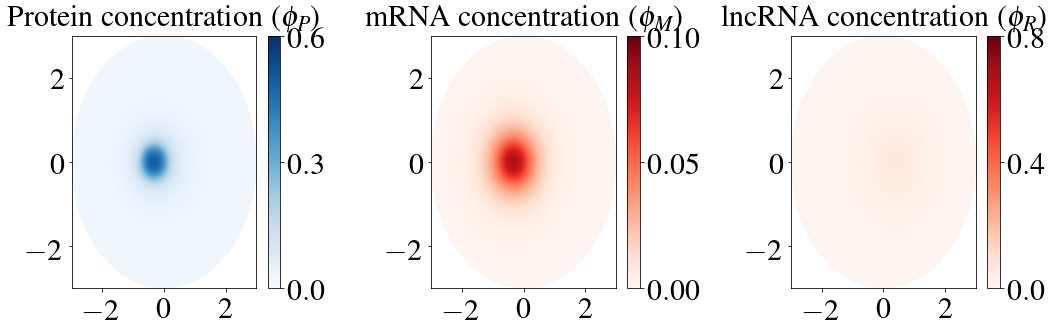

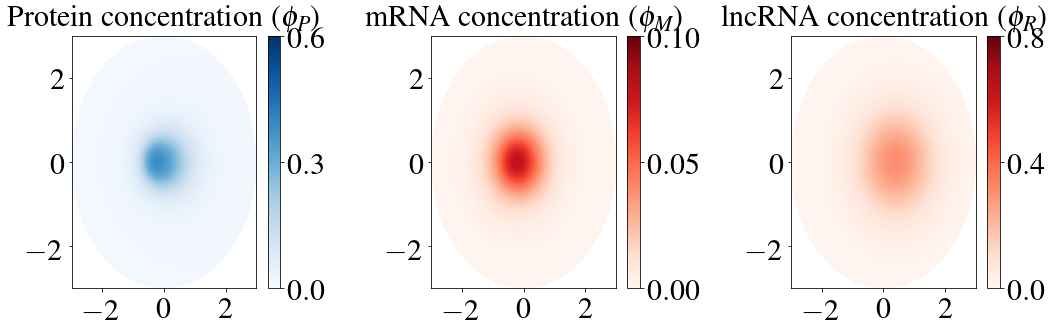

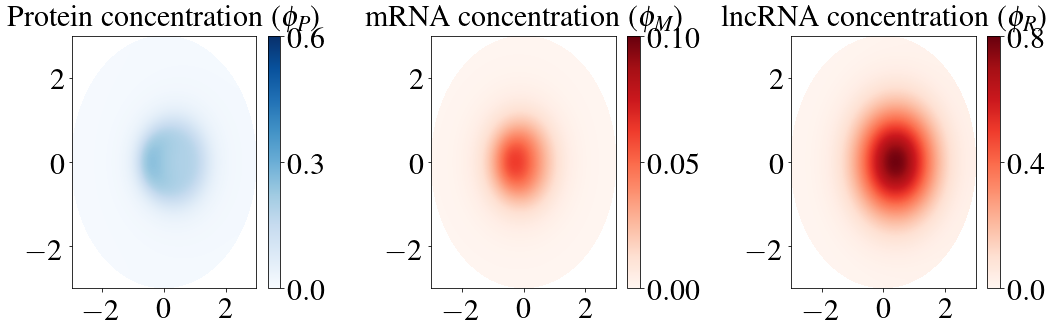

In [187]:
# Plotting the protein and lncRNA concentration profiles for phi_p = 0.04, phi_r = 0.001

delta = 0.2
sigma = 5.0
phi_p = 0.04

# k_pl_list = [0.002, 0.01, 0.025]
k_pl_list = [0.002, 0.01, 0.025]

#### One way to normalize phi_m
# k_deg = 0.02
# factor_for_average_rate = 0.95
# phi_m_bar = np.array(k_p_list)*factor_for_average_rate/k_deg

### Another way to normalize phi_m
chi_pm = 1.2
rho_m = 2.0
phi_m_bar = [chi_pm*0.3/rho_m]*len(k_pl_list) 

min_erna_val = 0.0
max_erna_val = 0.1

min_lrna_val = 0.0
max_lrna_val = 0.8

min_protein_val = 0.0
max_protein_val = 0.6

indices_without_well = [(mesh.y < delta) * (mesh.y > -delta) * (mesh.x < 12.0) * (mesh.x > -12.0)]
cmap_p = plt.get_cmap('Blues')
cmap_m = plt.get_cmap('Reds')

for i in range(len(k_pl_list)):
    fig,axs = plt.subplots(1,3,figsize=(15,5))
    cs1 = axs[0].tricontourf(mesh.x/sigma, mesh.y/sigma, data[k_pl_list[i]]['phi_p'].value,
                   levels=np.linspace(min_protein_val,max_protein_val,256), cmap='Blues')
    cs2 = axs[1].tricontourf(mesh.x/sigma, mesh.y/sigma, data[k_pl_list[i]]['phi_m'].value,
                   levels=np.linspace(min_erna_val,max_erna_val,256), cmap='Reds')
    cs3 = axs[2].tricontourf(mesh.x/sigma, mesh.y/sigma, data[k_pl_list[i]]['phi_r'].value,
                   levels=np.linspace(min_lrna_val,max_lrna_val,256), cmap='Reds')
    axs[0].tick_params(axis='both', which='major', labelsize=30)
    axs[1].tick_params(axis='both', which='major', labelsize=30)
    axs[2].tick_params(axis='both', which='major', labelsize=30)
    cbar1 = fig.colorbar(cs1, ax=axs[0], ticks=np.linspace(min_protein_val,max_protein_val,3))
    cbar2 = fig.colorbar(cs2, ax=axs[1], ticks=np.linspace(min_erna_val,max_erna_val,3))
    cbar3 = fig.colorbar(cs3, ax=axs[2], ticks=np.linspace(min_lrna_val,max_lrna_val,3))
    cbar1.ax.tick_params(labelsize=30)
    cbar2.ax.tick_params(labelsize=30)
    cbar3.ax.tick_params(labelsize=30)
    axs[0].set_title(r'Protein concentration ($\phi_P$)',fontsize=30)
    axs[1].set_title(r'mRNA concentration ($\phi_M$)',fontsize=30)
    axs[2].set_title(r'lncRNA concentration ($\phi_R$)',fontsize=30)
    axs[0].xaxis.set_ticks(np.arange(-2.0, 2.1, 2.0))
    axs[0].yaxis.set_ticks(np.arange(-2.0, 2.1, 2.0))
    axs[1].xaxis.set_ticks(np.arange(-2.0, 2.1, 2.0))
    axs[1].yaxis.set_ticks(np.arange(-2.0, 2.1, 2.0))
    axs[2].xaxis.set_ticks(np.arange(-2.0, 2.1, 2.0))
    axs[2].yaxis.set_ticks(np.arange(-2.0, 2.1, 2.0))
    plt.savefig('20220223 - Figures for paper/2d_concentration_profile_{kp}_kpl_ss.svg'.format(kp=k_pl_list[i]), format='svg')   

In [196]:
k_pl_list = [0.002, 0.01, 0.025]

# no lncRNA
target_directory = '/nfs/arupclab001/npradeep96/PhaseField/ACTIVE_MRNA_LNCRNA/MODIFIED_FH_NO_PHIP_COUPLING_VARY_kp_kl/'
name_pattern = "phi_p0_0.04_k_p_lncRNA_{p}_.*_k_p_0.01_.*_Mmrna_0.1_.*_c_max_0.2_phi_r_00.0$"
mesh, data = get_protein_concentration_profiles(param_list=k_pl_list,  
                                                target_directory=target_directory, 
                                                name_pattern=name_pattern, time_step=6, nx=300, dx=0.1, sigma=5.0, 
                                                L_P=[4.0]*len(k_pl_list))

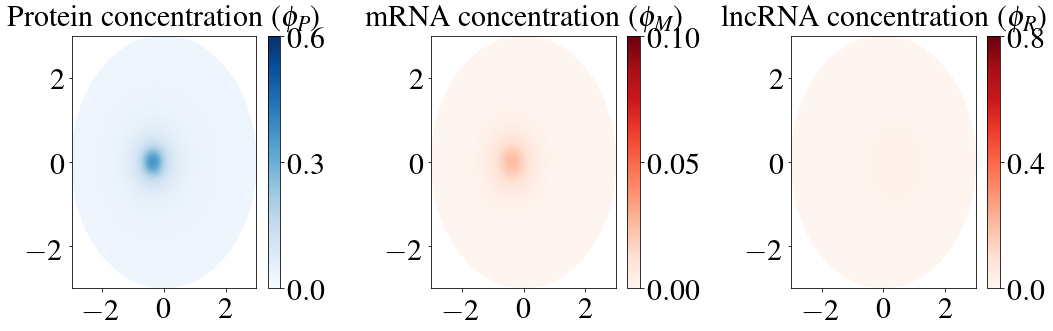

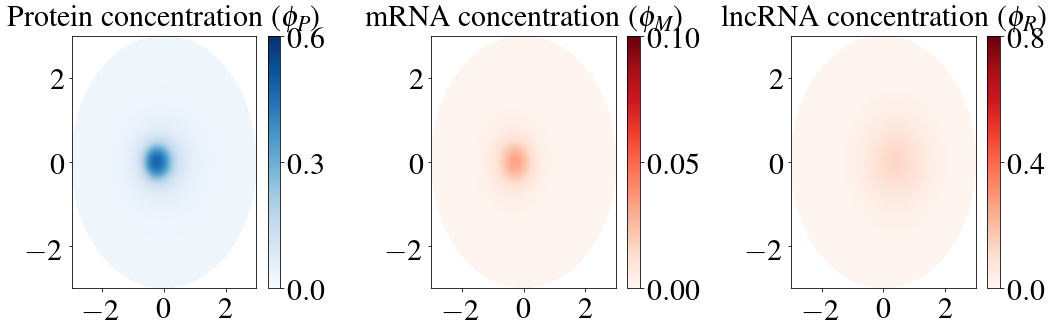

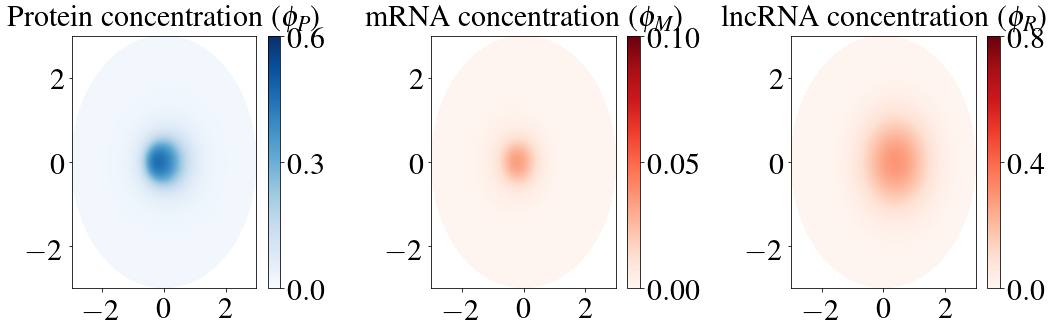

In [197]:
# Plotting the protein and lncRNA concentration profiles for phi_p = 0.04, phi_r = 0.001

delta = 0.2
sigma = 5.0
phi_p = 0.04

k_pl_list = [0.002, 0.01, 0.025]

#### One way to normalize phi_m
# k_deg = 0.02
# factor_for_average_rate = 0.95
# phi_m_bar = np.array(k_p_list)*factor_for_average_rate/k_deg

### Another way to normalize phi_m
chi_pm = 1.2
rho_m = 2.0
phi_m_bar = [chi_pm*0.3/rho_m]*len(k_pl_list) 

min_erna_val = 0.0
max_erna_val = 0.1

min_lrna_val = 0.0
max_lrna_val = 0.8

min_protein_val = 0.0
max_protein_val = 0.6

indices_without_well = [(mesh.y < delta) * (mesh.y > -delta) * (mesh.x < 12.0) * (mesh.x > -12.0)]
cmap_p = plt.get_cmap('Blues')
cmap_m = plt.get_cmap('Reds')

for i in range(len(k_pl_list)):
    fig,axs = plt.subplots(1,3,figsize=(15,5))
    cs1 = axs[0].tricontourf(mesh.x/sigma, mesh.y/sigma, data[k_pl_list[i]]['phi_p'].value,
                   levels=np.linspace(min_protein_val,max_protein_val,256), cmap='Blues')
    cs2 = axs[1].tricontourf(mesh.x/sigma, mesh.y/sigma, data[k_pl_list[i]]['phi_m'].value,
                   levels=np.linspace(min_erna_val,max_erna_val,256), cmap='Reds')
    cs3 = axs[2].tricontourf(mesh.x/sigma, mesh.y/sigma, data[k_pl_list[i]]['phi_r'].value,
                   levels=np.linspace(min_lrna_val,max_lrna_val,256), cmap='Reds')
    axs[0].tick_params(axis='both', which='major', labelsize=30)
    axs[1].tick_params(axis='both', which='major', labelsize=30)
    axs[2].tick_params(axis='both', which='major', labelsize=30)
    cbar1 = fig.colorbar(cs1, ax=axs[0], ticks=np.linspace(min_protein_val,max_protein_val,3))
    cbar2 = fig.colorbar(cs2, ax=axs[1], ticks=np.linspace(min_erna_val,max_erna_val,3))
    cbar3 = fig.colorbar(cs3, ax=axs[2], ticks=np.linspace(min_lrna_val,max_lrna_val,3))
    cbar1.ax.tick_params(labelsize=30)
    cbar2.ax.tick_params(labelsize=30)
    cbar3.ax.tick_params(labelsize=30)
    axs[0].set_title(r'Protein concentration ($\phi_P$)',fontsize=30)
    axs[1].set_title(r'mRNA concentration ($\phi_M$)',fontsize=30)
    axs[2].set_title(r'lncRNA concentration ($\phi_R$)',fontsize=30)
    axs[0].xaxis.set_ticks(np.arange(-2.0, 2.1, 2.0))
    axs[0].yaxis.set_ticks(np.arange(-2.0, 2.1, 2.0))
    axs[1].xaxis.set_ticks(np.arange(-2.0, 2.1, 2.0))
    axs[1].yaxis.set_ticks(np.arange(-2.0, 2.1, 2.0))
    axs[2].xaxis.set_ticks(np.arange(-2.0, 2.1, 2.0))
    axs[2].yaxis.set_ticks(np.arange(-2.0, 2.1, 2.0))
    plt.savefig('20220223 - Figures for paper/2d_concentration_profile_{kp}_kpl_t_6.svg'.format(kp=k_pl_list[i]), format='svg')   

In [194]:
k_pl_list = [0.002, 0.01, 0.025]

# no lncRNA
target_directory = '/nfs/arupclab001/npradeep96/PhaseField/ACTIVE_MRNA_LNCRNA/MODIFIED_FH_NO_PHIP_COUPLING_VARY_kp_kl/'
name_pattern = "phi_p0_0.04_k_p_lncRNA_{p}_.*_k_p_0.01_.*_Mmrna_0.1_.*_c_max_0.2_phi_r_00.0$"
mesh, data = get_protein_concentration_profiles(param_list=k_pl_list,  
                                                target_directory=target_directory, 
                                                name_pattern=name_pattern, time_step=0, nx=300, dx=0.1, sigma=5.0, 
                                                L_P=[4.0]*len(k_pl_list))

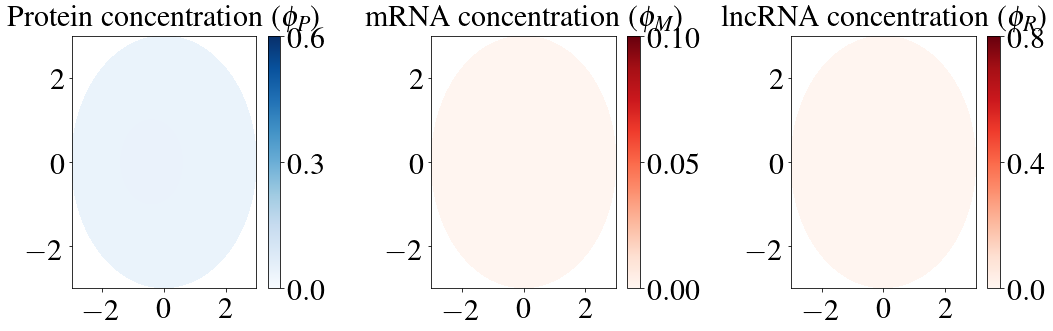

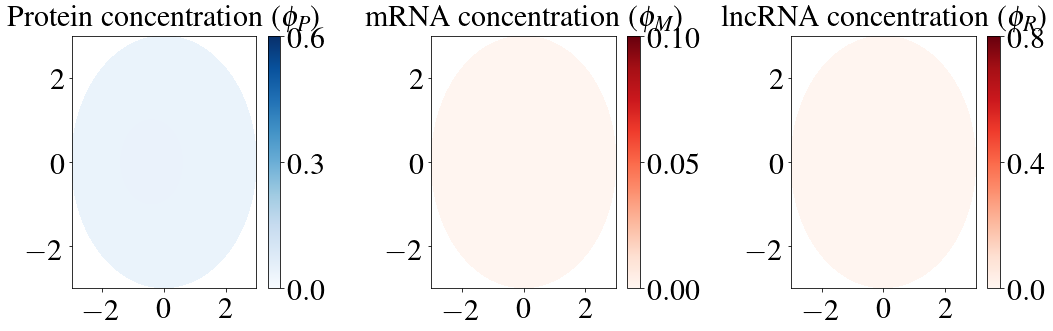

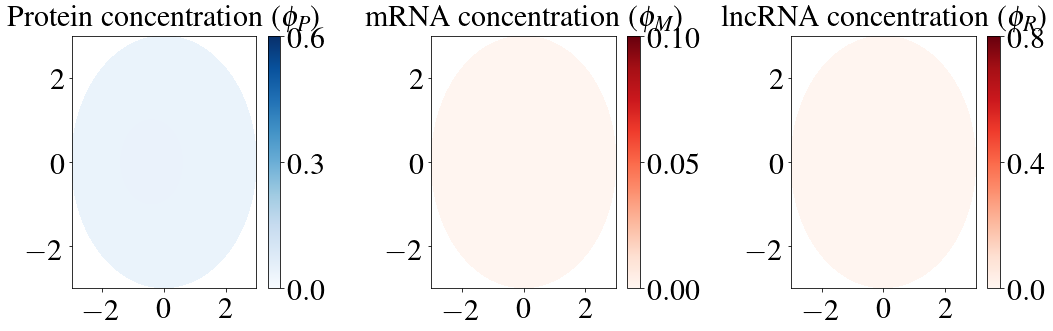

In [195]:
# Plotting the protein and lncRNA concentration profiles for phi_p = 0.04, phi_r = 0.001

delta = 0.2
sigma = 5.0
phi_p = 0.04

k_pl_list = [0.002, 0.01, 0.025]

#### One way to normalize phi_m
# k_deg = 0.02
# factor_for_average_rate = 0.95
# phi_m_bar = np.array(k_p_list)*factor_for_average_rate/k_deg

### Another way to normalize phi_m
chi_pm = 1.2
rho_m = 2.0
phi_m_bar = [chi_pm*0.3/rho_m]*len(k_pl_list) 

min_erna_val = 0.0
max_erna_val = 0.1

min_lrna_val = 0.0
max_lrna_val = 0.8

min_protein_val = 0.0
max_protein_val = 0.6

indices_without_well = [(mesh.y < delta) * (mesh.y > -delta) * (mesh.x < 12.0) * (mesh.x > -12.0)]
cmap_p = plt.get_cmap('Blues')
cmap_m = plt.get_cmap('Reds')

for i in range(len(k_pl_list)):
    fig,axs = plt.subplots(1,3,figsize=(15,5))
    cs1 = axs[0].tricontourf(mesh.x/sigma, mesh.y/sigma, data[k_pl_list[i]]['phi_p'].value,
                   levels=np.linspace(min_protein_val,max_protein_val,256), cmap='Blues')
    cs2 = axs[1].tricontourf(mesh.x/sigma, mesh.y/sigma, data[k_pl_list[i]]['phi_m'].value,
                   levels=np.linspace(min_erna_val,max_erna_val,256), cmap='Reds')
    cs3 = axs[2].tricontourf(mesh.x/sigma, mesh.y/sigma, data[k_pl_list[i]]['phi_r'].value,
                   levels=np.linspace(min_lrna_val,max_lrna_val,256), cmap='Reds')
    axs[0].tick_params(axis='both', which='major', labelsize=30)
    axs[1].tick_params(axis='both', which='major', labelsize=30)
    axs[2].tick_params(axis='both', which='major', labelsize=30)
    cbar1 = fig.colorbar(cs1, ax=axs[0], ticks=np.linspace(min_protein_val,max_protein_val,3))
    cbar2 = fig.colorbar(cs2, ax=axs[1], ticks=np.linspace(min_erna_val,max_erna_val,3))
    cbar3 = fig.colorbar(cs3, ax=axs[2], ticks=np.linspace(min_lrna_val,max_lrna_val,3))
    cbar1.ax.tick_params(labelsize=30)
    cbar2.ax.tick_params(labelsize=30)
    cbar3.ax.tick_params(labelsize=30)
    axs[0].set_title(r'Protein concentration ($\phi_P$)',fontsize=30)
    axs[1].set_title(r'mRNA concentration ($\phi_M$)',fontsize=30)
    axs[2].set_title(r'lncRNA concentration ($\phi_R$)',fontsize=30)
    axs[0].xaxis.set_ticks(np.arange(-2.0, 2.1, 2.0))
    axs[0].yaxis.set_ticks(np.arange(-2.0, 2.1, 2.0))
    axs[1].xaxis.set_ticks(np.arange(-2.0, 2.1, 2.0))
    axs[1].yaxis.set_ticks(np.arange(-2.0, 2.1, 2.0))
    axs[2].xaxis.set_ticks(np.arange(-2.0, 2.1, 2.0))
    axs[2].yaxis.set_ticks(np.arange(-2.0, 2.1, 2.0))
    plt.savefig('20220223 - Figures for paper/2d_concentration_profile_{kp}_kpl_t_0.svg'.format(kp=k_pl_list[i]), format='svg')   

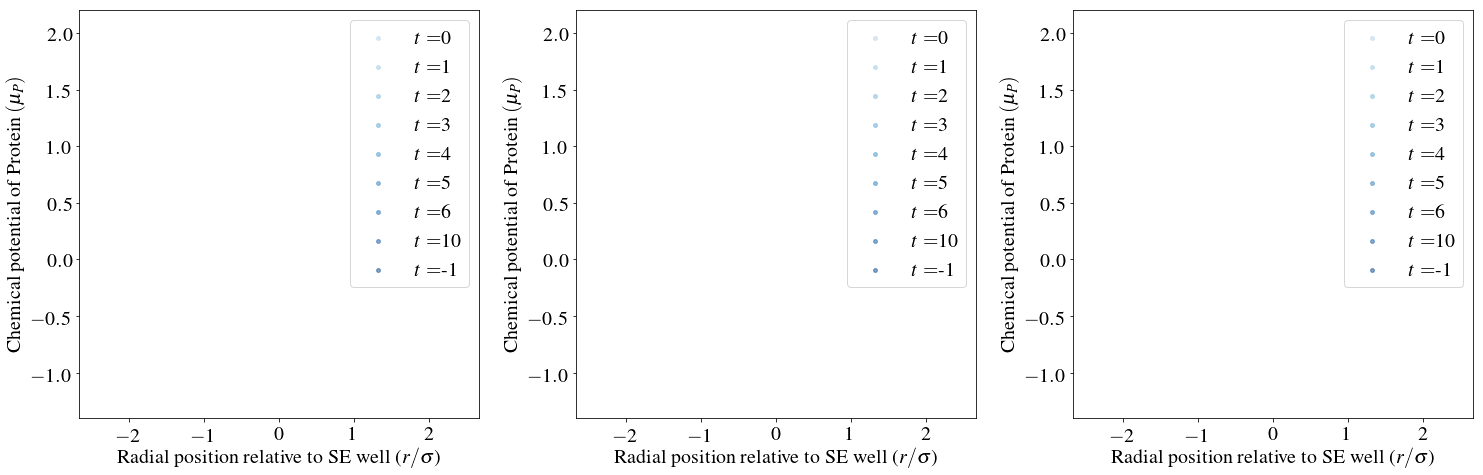

In [174]:
# Getting chemical potential plots to understand the distance effect

# localized lncRNA
k_l_list = [0.002, 0.01, 0.025]
times_list = [0, 1, 2, 3, 4, 5, 6, 10, -1]

target_directory = '/nfs/arupclab001/npradeep96/PhaseField/ACTIVE_MRNA_LNCRNA/MODIFIED_FH_NO_PHIP_COUPLING_VARY_kp_kl/'
name_pattern = "phi_p0_0.04_k_p_lncRNA_{p}_.*_k_p_0.1_.*_Mmrna_0.1_.*_c_max_0.2_phi_r_00.0$"

mesh_d_list = []
data_d_list = []

for i in range(len(times_list)):
    mesh_d, data_d = get_chemical_potential(param_list=k_l_list, 
                                                    target_directory=target_directory, 
                                                    name_pattern=name_pattern, nx=300, dx=0.1, sigma=5.0, 
                                                    L_P=[4.0]*3, step_number=times_list[i])
    mesh_d_list.append(mesh_d)
    data_d_list.append(data_d)

mesh_no_rna_list = []
data_no_rna_list = []

# c_max_list = [0.2]
# target_directory = '/nfs/arupclab001/npradeep96/PhaseField/PURE_PROTEIN/MODIFIED_FH_TRIAL_VARY_PHIP_CMAX'
# name_pattern = "phi_p0_0.04_.*_c_max_{p}$"

# for i in range(len(times_list)):
#     mesh_no_rna, data_no_rna =  get_chemical_potential(param_list=c_max_list, 
#                                                     target_directory=target_directory, 
#                                                     name_pattern=name_pattern, nx=300, dx=0.1, sigma=5.0, 
#                                                     L_P=[0.0], step_number=times_list[i])
#     mesh_no_rna_list.append(mesh_no_rna)
#     data_no_rna_list.append(data_no_rna)

delta = 0.2
sigma = 5.0

cmap = plt.get_cmap('Blues')
color_vals = np.linspace(0.3,1.0,len(times_list)+1)

fig,axs = plt.subplots(1,len(k_l_list),figsize=(7*len(k_l_list),7))

indices_with_SE_well = [(mesh_d.y < delta) * (mesh_d.y > -delta) * (mesh_d.x < 12.0) * (mesh_d.x > -12.0)]

for i in range(len(k_l_list)):
    for j in range(len(times_list)):
        axs[i].scatter((np.array(mesh_d_list[j].x[indices_with_SE_well]))/sigma,
                    np.array(data_d_list[j][k_l_list[i]]['mu_p'][indices_with_SE_well]), label=r'$t=$'+str(times_list[j]), 
                    s=15, alpha=0.5, 
                    c=cmap(color_vals[j]))
    axs[i].legend()
    axs[i].set_xlabel('Radial position relative to SE well ($r/\sigma$)')
    axs[i].set_ylabel('Chemical potential of Protein $(\mu_P)$')  
    axs[i].set_ylim([-2.2,-1.4])

### Dynamics

In [331]:
k_p_list = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5]
# k_p_list = [0.01]
# k_pl_list = [0.5]
k_pl_list = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5]

# no lncRNA
target_directory = '/nfs/arupclab001/npradeep96/PhaseField/ACTIVE_MRNA_LNCRNA/MODIFIED_FH_VARY_kp_kl'
for i in range(len(target_directory)):
    name_pattern = ("phi_p0_0.04_k_p_lncRNA_{kpl}_".format(kpl=k_pl_list[i]) 
                    + ".*_k_p_{p}_.*_Mmrna_0.1_.*_c_max_0.2_phi_r_00.0$")
    generate_dynamical_trajectories(param_list=k_p_list,  
                                    target_directory=target_directory, 
                                    name_pattern=name_pattern, nx=300, dx=0.1)

Succesfully wrote data to /nfs/arupclab001/npradeep96/PhaseField/ACTIVE_MRNA_LNCRNA/MODIFIED_FH_VARY_kp_kl/phi_p0_0.04_k_p_lncRNA_0.001_L_P_4.0_k_p_0.001_reactiontype_2.0_thresh_0.0_FE_8.0_MP_100.0_Mmrna_0.1_M_rna_0.1_c_max_0.2_phi_r_00.0/dynamical_trajectories.hdf5 ...
Succesfully wrote data to /nfs/arupclab001/npradeep96/PhaseField/ACTIVE_MRNA_LNCRNA/MODIFIED_FH_VARY_kp_kl/phi_p0_0.04_k_p_lncRNA_0.001_L_P_4.0_k_p_0.005_reactiontype_2.0_thresh_0.0_FE_8.0_MP_100.0_Mmrna_0.1_M_rna_0.1_c_max_0.2_phi_r_00.0/dynamical_trajectories.hdf5 ...
Succesfully wrote data to /nfs/arupclab001/npradeep96/PhaseField/ACTIVE_MRNA_LNCRNA/MODIFIED_FH_VARY_kp_kl/phi_p0_0.04_k_p_lncRNA_0.001_L_P_4.0_k_p_0.01_reactiontype_2.0_thresh_0.0_FE_8.0_MP_100.0_Mmrna_0.1_M_rna_0.1_c_max_0.2_phi_r_00.0/dynamical_trajectories.hdf5 ...
Succesfully wrote data to /nfs/arupclab001/npradeep96/PhaseField/ACTIVE_MRNA_LNCRNA/MODIFIED_FH_VARY_kp_kl/phi_p0_0.04_k_p_lncRNA_0.001_L_P_4.0_k_p_0.05_reactiontype_2.0_thresh_0.0_FE_8.0_

Succesfully wrote data to /nfs/arupclab001/npradeep96/PhaseField/ACTIVE_MRNA_LNCRNA/MODIFIED_FH_VARY_kp_kl/phi_p0_0.04_k_p_lncRNA_0.5_L_P_0.0_k_p_0.005_reactiontype_2.0_thresh_0.0_FE_8.0_MP_100.0_Mmrna_0.1_M_rna_0.1_c_max_0.2_phi_r_00.0/dynamical_trajectories.hdf5 ...
Succesfully wrote data to /nfs/arupclab001/npradeep96/PhaseField/ACTIVE_MRNA_LNCRNA/MODIFIED_FH_VARY_kp_kl/phi_p0_0.04_k_p_lncRNA_0.5_L_P_0.0_k_p_0.01_reactiontype_2.0_thresh_0.0_FE_8.0_MP_100.0_Mmrna_0.1_M_rna_0.1_c_max_0.2_phi_r_00.0/dynamical_trajectories.hdf5 ...
Succesfully wrote data to /nfs/arupclab001/npradeep96/PhaseField/ACTIVE_MRNA_LNCRNA/MODIFIED_FH_VARY_kp_kl/phi_p0_0.04_k_p_lncRNA_0.5_L_P_0.0_k_p_0.05_reactiontype_2.0_thresh_0.0_FE_8.0_MP_100.0_Mmrna_0.1_M_rna_0.1_c_max_0.2_phi_r_00.0/dynamical_trajectories.hdf5 ...
Succesfully wrote data to /nfs/arupclab001/npradeep96/PhaseField/ACTIVE_MRNA_LNCRNA/MODIFIED_FH_VARY_kp_kl/phi_p0_0.04_k_p_lncRNA_0.5_L_P_0.0_k_p_0.1_reactiontype_2.0_thresh_0.0_FE_8.0_MP_100.0_M

/home/npradeep96/miniconda3/envs/fipyenv/lib/python2.7/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in divide
/home/npradeep96/miniconda3/envs/fipyenv/lib/python2.7/site-packages/ipykernel_launcher.py:120: RuntimeWarning: invalid value encountered in divide


ValueError: Index (41) out of range (0-40)

In [39]:
k_p_list = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5]
# k_p_list = [0.01]
# k_pl_list = [0.5]
k_pl_list = [0.0002, 0.001, 0.002, 0.003, 0.005, 0.01, 0.015, 0.02, 0.025]

# no lncRNA
target_directory = '/nfs/arupclab001/npradeep96/PhaseField/ACTIVE_MRNA_LNCRNA/MODIFIED_FH_NO_PHIP_COUPLING_VARY_kp_kl'
for i in range(len(target_directory)):
    name_pattern = ("phi_p0_0.04_k_p_lncRNA_{kpl}_".format(kpl=k_pl_list[i]) 
                    + ".*_k_p_{p}_.*_Mmrna_0.1_.*_c_max_0.2_phi_r_00.0$")
    generate_dynamical_trajectories(param_list=k_p_list,  
                                    target_directory=target_directory, 
                                    name_pattern=name_pattern, nx=300, dx=0.1)

Succesfully wrote data to /nfs/arupclab001/npradeep96/PhaseField/ACTIVE_MRNA_LNCRNA/MODIFIED_FH_NO_PHIP_COUPLING_VARY_kp_kl/phi_p0_0.04_k_p_lncRNA_0.0002_L_P_4.0_k_p_0.001_reactiontype_2.0_thresh_0.0_FE_8.0_MP_100.0_Mmrna_0.1_M_rna_0.1_c_max_0.2_phi_r_00.0/dynamical_trajectories.hdf5 ...
Succesfully wrote data to /nfs/arupclab001/npradeep96/PhaseField/ACTIVE_MRNA_LNCRNA/MODIFIED_FH_NO_PHIP_COUPLING_VARY_kp_kl/phi_p0_0.04_k_p_lncRNA_0.0002_L_P_4.0_k_p_0.005_reactiontype_2.0_thresh_0.0_FE_8.0_MP_100.0_Mmrna_0.1_M_rna_0.1_c_max_0.2_phi_r_00.0/dynamical_trajectories.hdf5 ...
Succesfully wrote data to /nfs/arupclab001/npradeep96/PhaseField/ACTIVE_MRNA_LNCRNA/MODIFIED_FH_NO_PHIP_COUPLING_VARY_kp_kl/phi_p0_0.04_k_p_lncRNA_0.0002_L_P_4.0_k_p_0.01_reactiontype_2.0_thresh_0.0_FE_8.0_MP_100.0_Mmrna_0.1_M_rna_0.1_c_max_0.2_phi_r_00.0/dynamical_trajectories.hdf5 ...
Succesfully wrote data to /nfs/arupclab001/npradeep96/PhaseField/ACTIVE_MRNA_LNCRNA/MODIFIED_FH_NO_PHIP_COUPLING_VARY_kp_kl/phi_p0_0.0

Succesfully wrote data to /nfs/arupclab001/npradeep96/PhaseField/ACTIVE_MRNA_LNCRNA/MODIFIED_FH_NO_PHIP_COUPLING_VARY_kp_kl/phi_p0_0.04_k_p_lncRNA_0.005_L_P_4.0_k_p_0.5_reactiontype_2.0_thresh_0.0_FE_8.0_MP_100.0_Mmrna_0.1_M_rna_0.1_c_max_0.2_phi_r_00.0/dynamical_trajectories.hdf5 ...
Succesfully wrote data to /nfs/arupclab001/npradeep96/PhaseField/ACTIVE_MRNA_LNCRNA/MODIFIED_FH_NO_PHIP_COUPLING_VARY_kp_kl/phi_p0_0.04_k_p_lncRNA_0.01_L_P_4.0_k_p_0.001_reactiontype_2.0_thresh_0.0_FE_8.0_MP_100.0_Mmrna_0.1_M_rna_0.1_c_max_0.2_phi_r_00.0/dynamical_trajectories.hdf5 ...
Succesfully wrote data to /nfs/arupclab001/npradeep96/PhaseField/ACTIVE_MRNA_LNCRNA/MODIFIED_FH_NO_PHIP_COUPLING_VARY_kp_kl/phi_p0_0.04_k_p_lncRNA_0.01_L_P_4.0_k_p_0.005_reactiontype_2.0_thresh_0.0_FE_8.0_MP_100.0_Mmrna_0.1_M_rna_0.1_c_max_0.2_phi_r_00.0/dynamical_trajectories.hdf5 ...
Succesfully wrote data to /nfs/arupclab001/npradeep96/PhaseField/ACTIVE_MRNA_LNCRNA/MODIFIED_FH_NO_PHIP_COUPLING_VARY_kp_kl/phi_p0_0.04_k_p_

IndexError: list index out of range

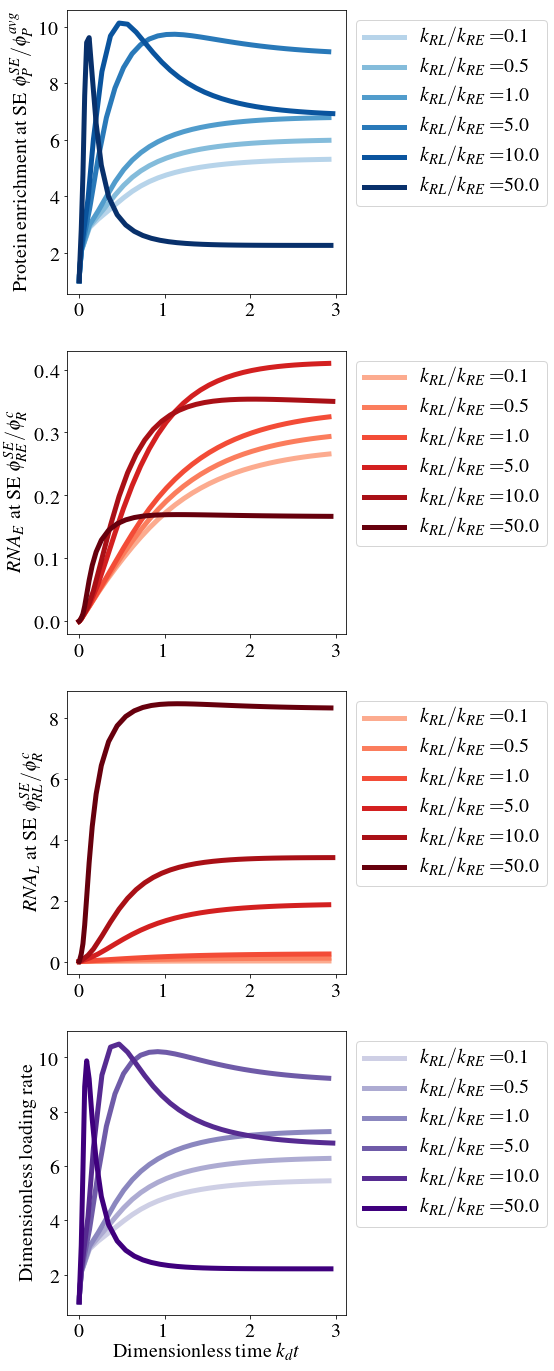

In [332]:
k_l_list = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5]
k_degradation = 0.02

target_directory_list = ['/nfs/arupclab001/npradeep96/PhaseField/ACTIVE_MRNA_LNCRNA/MODIFIED_FH_VARY_kp_kl/']
name_pattern_list = ["phi_p0_0.04_k_p_lncRNA_{p}_.*_k_p_0.01_.*_Mmrna_0.1_.*_c_max_0.2_phi_r_00.0$"]

# variable_names = ['fold_protein_in_SE', 'fold_erna_in_SE', 'condensate_area', 
#                   'fold_avg_eRNA', 'non_dim_avg_eRNA_production_rate', 'non_dim_avg_eRNA_net_rate', 
#                   'non_dim_rate_of_PolII_loading', 'non_dim_cumulative_PolII_loaded']
# ylabels = ['Protein vol. frac. at SE $\phi^{SE}_P/\phi^{avg}_P$',
#            'RNA vol. frac. at SE $\phi^{SE}_R/\phi^c_R$', 'Condensate Area $A/\pi\sigma^2$', 
#            'RNA vol. frac. in system $\phi^{avg}_R/\phi^c_R$', 
#            'RNA production rate $\int k_p(r)\phi_p(r)dV/(k_d\phi^c_R)$',
#            'net rate of RNA $\uparrow ~ 1/(k_d\phi^c_R)\partial \phi^{avg}_R/\partial t$',
#            # 'Rate of Pol II loading $\int Gaussian(r)\phi_p(r)dV$', 
#            'Rate of Pol II loading', 
#            'Total Pol II loaded $1/(\phi^{avg}_PV)\int\int G(r)\phi_p(r)dVdt$']
# cmaps = ['Blues', 'Reds', 'Blues', 'Reds', 'Reds', 'Reds', 'Purples', 'Purples']

variable_names = ['fold_protein_in_SE', 'fold_erna_in_SE', 'fold_lncrna_in_SE',
                  'non_dim_rate_of_PolII_loading']
ylabels = ['Protein enrichment at SE $\phi^{SE}_P/\phi^{avg}_P$',
           '$RNA_E$ at SE $\phi^{SE}_{RE}/\phi^c_R$', '$RNA_L$ at SE $\phi^{SE}_{RL}/\phi^c_R$', 
           'Dimensionless loading rate']
cmaps = ['Blues', 'Reds', 'Reds', 'Purples']

N = len(variable_names)

fig, axs = plt.subplots(N,1,figsize=(5,6*N))
color_vals = np.linspace(0.3,1.0,len(k_l_list))

for j in range(len(variable_names)):
    trajectories = get_list_of_trajectories(param_list=k_l_list,
                                            target_directory_list=target_directory_list,
                                            name_pattern_list=name_pattern_list,
                                            variable_name=variable_names[j])
    cmap = plt.get_cmap(cmaps[j])
    for i in range(len(k_l_list)):
        axs[j].plot(k_degradation*trajectories[0][k_l_list[i]]['t'], trajectories[0][k_l_list[i]][variable_names[j]], 
                    '-', c=cmap(color_vals[i]), label="$k_{RL}/k_{RE}=$"+"{kp}".format(kp=k_l_list[i]/0.01),linewidth=5.0)

    axs[j].set_ylabel(ylabels[j])
    # axs[j].set_xlim([-0.1,5.0])
    axs[j].legend(bbox_to_anchor=(1, 1), loc='left', ncol=1)

axs[j].set_xlabel('Dimensionless time $k_dt$')
plt.savefig('20220223 - Figures for paper/dynamics_vs_k_pl.svg', format='svg', dpi=600)

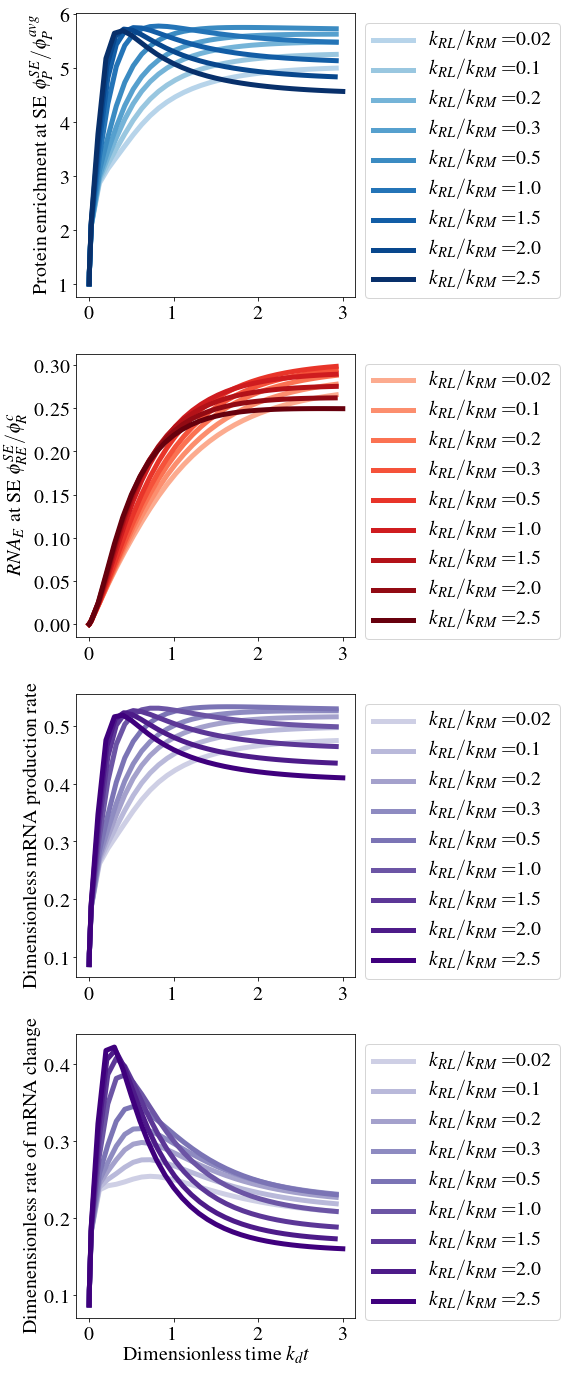

In [42]:
k_l_list = [0.0002, 0.001, 0.002, 0.003, 0.005, 0.01, 0.015, 0.02, 0.025]
k_degradation = 0.02

target_directory_list = ['/nfs/arupclab001/npradeep96/PhaseField/ACTIVE_MRNA_LNCRNA/MODIFIED_FH_NO_PHIP_COUPLING_VARY_kp_kl/']
name_pattern_list = ["phi_p0_0.04_k_p_lncRNA_{p}_.*_k_p_0.01_.*_Mmrna_0.1_.*_c_max_0.2_phi_r_00.0$"]

# variable_names = ['fold_protein_in_SE', 'fold_erna_in_SE', 'condensate_area', 
#                   'fold_avg_eRNA', 'non_dim_avg_eRNA_production_rate', 'non_dim_avg_eRNA_net_rate', 
#                   'non_dim_rate_of_PolII_loading', 'non_dim_cumulative_PolII_loaded']
# ylabels = ['Protein vol. frac. at SE $\phi^{SE}_P/\phi^{avg}_P$',
#            'RNA vol. frac. at SE $\phi^{SE}_R/\phi^c_R$', 'Condensate Area $A/\pi\sigma^2$', 
#            'RNA vol. frac. in system $\phi^{avg}_R/\phi^c_R$', 
#            'RNA production rate $\int k_p(r)\phi_p(r)dV/(k_d\phi^c_R)$',
#            'net rate of RNA $\uparrow ~ 1/(k_d\phi^c_R)\partial \phi^{avg}_R/\partial t$',
#            # 'Rate of Pol II loading $\int Gaussian(r)\phi_p(r)dV$', 
#            'Rate of Pol II loading', 
#            'Total Pol II loaded $1/(\phi^{avg}_PV)\int\int G(r)\phi_p(r)dVdt$']
# cmaps = ['Blues', 'Reds', 'Blues', 'Reds', 'Reds', 'Reds', 'Purples', 'Purples']

variable_names = ['fold_protein_in_SE', 'fold_erna_in_SE', # 'fold_lncrna_in_SE',
                  'non_dim_avg_eRNA_production_rate', 'non_dim_avg_eRNA_net_rate']
ylabels = ['Protein enrichment at SE $\phi^{SE}_P/\phi^{avg}_P$',
           '$RNA_E$ at SE $\phi^{SE}_{RE}/\phi^c_R$', # '$RNA_L$ at SE $\phi^{SE}_{RL}/\phi^c_R$', 
           'Dimensionless mRNA production rate', 'Dimenensionless rate of mRNA change']
cmaps = ['Blues', 'Reds', 'Purples', 'Purples']

N = len(variable_names)

fig, axs = plt.subplots(N,1,figsize=(5,6*N))
color_vals = np.linspace(0.3,1.0,len(k_l_list))

for j in range(len(variable_names)):
    trajectories = get_list_of_trajectories(param_list=k_l_list,
                                            target_directory_list=target_directory_list,
                                            name_pattern_list=name_pattern_list,
                                            variable_name=variable_names[j])
    cmap = plt.get_cmap(cmaps[j])
    for i in range(len(k_l_list)):
        axs[j].plot(k_degradation*trajectories[0][k_l_list[i]]['t'], trajectories[0][k_l_list[i]][variable_names[j]], 
                    '-', c=cmap(color_vals[i]), label="$k_{RL}/k_{RM}=$"+"{kp}".format(kp=k_l_list[i]/0.01),linewidth=5.0)

    axs[j].set_ylabel(ylabels[j])
    # axs[j].set_xlim([-0.1,5.0])
    # axs[j].legend(bbox_to_anchor=(1, 1), loc='left', ncol=1)
    axs[j].legend(bbox_to_anchor=(1, 1), loc='left', ncol=1)

axs[j].set_xlabel('Dimensionless time $k_dt$')
plt.savefig('20220223 - Figures for paper/dynamics_vs_k_pl_no_protein_coupling.svg', format='svg', dpi=600)

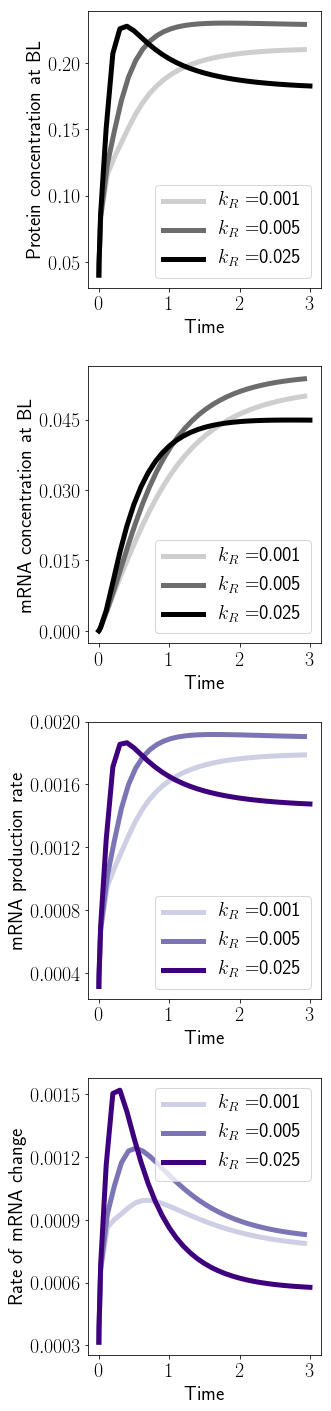

In [101]:
k_l_list = [0.001, 0.005, 0.025]
k_degradation = 0.02

target_directory_list = ['/nfs/arupclab001/npradeep96/PhaseField/ACTIVE_MRNA_LNCRNA/MODIFIED_FH_NO_PHIP_COUPLING_VARY_kp_kl/']
name_pattern_list = ["phi_p0_0.04_k_p_lncRNA_{p}_.*_k_p_0.01_.*_Mmrna_0.1_.*_c_max_0.2_phi_r_00.0$"]

# variable_names = ['fold_protein_in_SE', 'fold_erna_in_SE', 'condensate_area', 
#                   'fold_avg_eRNA', 'non_dim_avg_eRNA_production_rate', 'non_dim_avg_eRNA_net_rate', 
#                   'non_dim_rate_of_PolII_loading', 'non_dim_cumulative_PolII_loaded']
# ylabels = ['Protein vol. frac. at SE $\phi^{SE}_P/\phi^{avg}_P$',
#            'RNA vol. frac. at SE $\phi^{SE}_R/\phi^c_R$', 'Condensate Area $A/\pi\sigma^2$', 
#            'RNA vol. frac. in system $\phi^{avg}_R/\phi^c_R$', 
#            'RNA production rate $\int k_p(r)\phi_p(r)dV/(k_d\phi^c_R)$',
#            'net rate of RNA $\uparrow ~ 1/(k_d\phi^c_R)\partial \phi^{avg}_R/\partial t$',
#            # 'Rate of Pol II loading $\int Gaussian(r)\phi_p(r)dV$', 
#            'Rate of Pol II loading', 
#            'Total Pol II loaded $1/(\phi^{avg}_PV)\int\int G(r)\phi_p(r)dVdt$']
# cmaps = ['Blues', 'Reds', 'Blues', 'Reds', 'Reds', 'Reds', 'Purples', 'Purples']

variable_names = ['protein_in_SE', 'erna_in_SE', # 'fold_lncrna_in_SE',
                  'avg_eRNA_production_rate', 'avg_eRNA_net_rate']
ylabels = ['Protein concentration at BL', # 'Protein enrichment at SE $\phi^{SE}_P/\phi^{avg}_P$',
           'mRNA concentration at BL', # '$RNA_L$ at SE $\phi^{SE}_{RL}/\phi^c_R$', 
           'mRNA production rate', 'Rate of mRNA change']
cmaps = ['Greys', 'Greys', 'Purples', 'Purples']

N = len(variable_names)

fig, axs = plt.subplots(N,1,figsize=(5, 5*N))
color_vals = np.linspace(0.3,1.0,len(k_l_list))

for j in range(len(variable_names)):
    trajectories = get_list_of_trajectories(param_list=k_l_list,
                                            target_directory_list=target_directory_list,
                                            name_pattern_list=name_pattern_list,
                                            variable_name=variable_names[j])
    cmap = plt.get_cmap(cmaps[j])
    for i in range(len(k_l_list)):
        if variable_names[j] == 'fold_protein_in_SE':
            axs[j].plot(k_degradation*trajectories[0][k_l_list[i]]['t'], trajectories[0][k_l_list[i]][variable_names[j]], 
                    '-', c=cmap(color_vals[i]), label="$k_{R}=$"+"{kp}".format(kp=k_l_list[i]),linewidth=5.0)
            # print('hi')
        else: 
            axs[j].plot(k_degradation*trajectories[0][k_l_list[i]]['t'], trajectories[0][k_l_list[i]][variable_names[j]], 
                    '-', c=cmap(color_vals[i]), label="$k_{R}=$"+"{kp}".format(kp=k_l_list[i]),linewidth=5.0)

    axs[j].set_ylabel(ylabels[j])
    axs[j].yaxis.set_major_locator(MaxNLocator(5))
    axs[j].xaxis.set_major_locator(MaxNLocator(4))
    # axs[j].set_xlim([-0.1,5.0])
    axs[j].legend()
    axs[j].set_xlabel('Time')
plt.savefig('20220223 - Figures for paper/dynamics_vs_k_pl_no_protein_coupling.svg', format='svg', dpi=600)

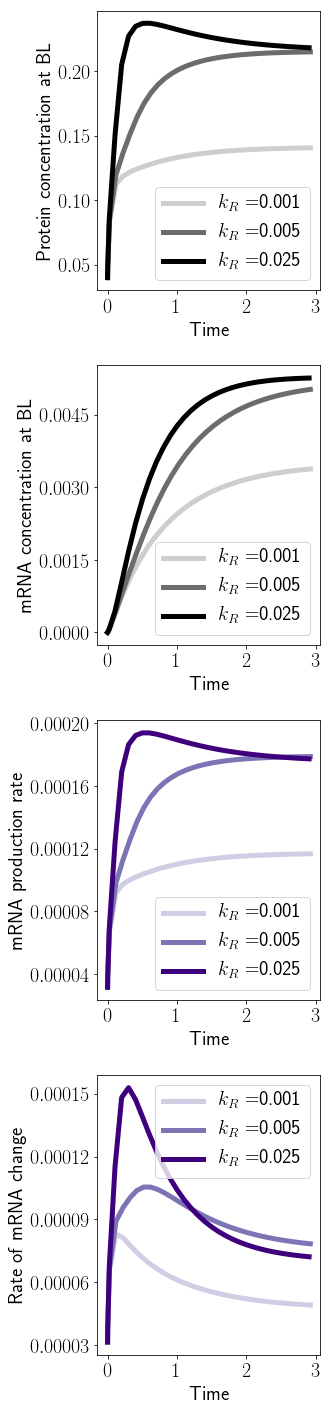

In [102]:
k_l_list = [0.001, 0.005, 0.025]
k_degradation = 0.02

target_directory_list = ['/nfs/arupclab001/npradeep96/PhaseField/ACTIVE_MRNA_LNCRNA/MODIFIED_FH_NO_PHIP_COUPLING_VARY_kp_kl/']
name_pattern_list = ["phi_p0_0.04_k_p_lncRNA_{p}_.*_k_p_0.001_.*_Mmrna_0.1_.*_c_max_0.2_phi_r_00.0$"]

# variable_names = ['fold_protein_in_SE', 'fold_erna_in_SE', 'condensate_area', 
#                   'fold_avg_eRNA', 'non_dim_avg_eRNA_production_rate', 'non_dim_avg_eRNA_net_rate', 
#                   'non_dim_rate_of_PolII_loading', 'non_dim_cumulative_PolII_loaded']
# ylabels = ['Protein vol. frac. at SE $\phi^{SE}_P/\phi^{avg}_P$',
#            'RNA vol. frac. at SE $\phi^{SE}_R/\phi^c_R$', 'Condensate Area $A/\pi\sigma^2$', 
#            'RNA vol. frac. in system $\phi^{avg}_R/\phi^c_R$', 
#            'RNA production rate $\int k_p(r)\phi_p(r)dV/(k_d\phi^c_R)$',
#            'net rate of RNA $\uparrow ~ 1/(k_d\phi^c_R)\partial \phi^{avg}_R/\partial t$',
#            # 'Rate of Pol II loading $\int Gaussian(r)\phi_p(r)dV$', 
#            'Rate of Pol II loading', 
#            'Total Pol II loaded $1/(\phi^{avg}_PV)\int\int G(r)\phi_p(r)dVdt$']
# cmaps = ['Blues', 'Reds', 'Blues', 'Reds', 'Reds', 'Reds', 'Purples', 'Purples']

variable_names = ['protein_in_SE', 'erna_in_SE', # 'fold_lncrna_in_SE',
                  'avg_eRNA_production_rate', 'avg_eRNA_net_rate']
ylabels = ['Protein concentration at BL', # 'Protein enrichment at SE $\phi^{SE}_P/\phi^{avg}_P$',
           'mRNA concentration at BL', # '$RNA_L$ at SE $\phi^{SE}_{RL}/\phi^c_R$', 
           'mRNA production rate', 'Rate of mRNA change']
cmaps = ['Greys', 'Greys', 'Purples', 'Purples']

N = len(variable_names)

fig, axs = plt.subplots(N,1,figsize=(5, 5*N))
color_vals = np.linspace(0.3,1.0,len(k_l_list))

for j in range(len(variable_names)):
    trajectories = get_list_of_trajectories(param_list=k_l_list,
                                            target_directory_list=target_directory_list,
                                            name_pattern_list=name_pattern_list,
                                            variable_name=variable_names[j])
    cmap = plt.get_cmap(cmaps[j])
    for i in range(len(k_l_list)):
        if variable_names[j] == 'fold_protein_in_SE':
            axs[j].plot(k_degradation*trajectories[0][k_l_list[i]]['t'], trajectories[0][k_l_list[i]][variable_names[j]], 
                    '-', c=cmap(color_vals[i]), label="$k_{R}=$"+"{kp}".format(kp=k_l_list[i]),linewidth=5.0)
            # print('hi')
        else: 
            axs[j].plot(k_degradation*trajectories[0][k_l_list[i]]['t'], trajectories[0][k_l_list[i]][variable_names[j]], 
                    '-', c=cmap(color_vals[i]), label="$k_{R}=$"+"{kp}".format(kp=k_l_list[i]),linewidth=5.0)

    axs[j].set_ylabel(ylabels[j])
    axs[j].yaxis.set_major_locator(MaxNLocator(5))
    axs[j].xaxis.set_major_locator(MaxNLocator(4))
    # axs[j].set_xlim([-0.1,5.0])
    axs[j].legend()
    axs[j].set_xlabel('Time')
plt.savefig('20220223 - Figures for paper/dynamics_vs_k_pl_no_protein_coupling_0.001.svg', format='svg', dpi=600)

(0, 0.8)

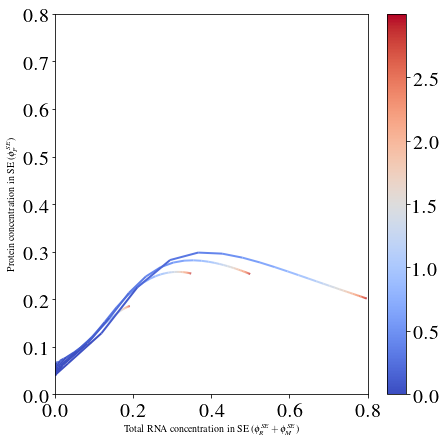

In [16]:
# Plot of phi_p_se vs phi_r_se for different distances

# k_l_list = [0.0002, 0.001, 0.002, 0.003, 0.005, 0.01, 0.015, 0.02, 0.025]
k_l_list = [0.0002, 0.002, 0.005, 0.01, 0.015, 0.025]
target_directory_list = ['/nfs/arupclab001/npradeep96/PhaseField/ACTIVE_MRNA_LNCRNA/MODIFIED_FH_NO_PHIP_COUPLING_VARY_kp_kl/']
name_pattern_list = ["phi_p0_0.04_k_p_lncRNA_{p}_.*_k_p_0.01_.*_Mmrna_0.1_.*_c_max_0.2_phi_r_00.0$"]


D_protein = 100
R = 15.0
phi_p = 0.04
k_degradation = 0.02

fig, axs = plt.subplots(1, 1, figsize=(7,7))

trajectories_p = get_list_of_trajectories(param_list=k_l_list,
                                            target_directory_list=target_directory_list,
                                            name_pattern_list=name_pattern_list,
                                            variable_name='protein_in_SE')
trajectories_l = get_list_of_trajectories(param_list=k_l_list,
                                            target_directory_list=target_directory_list,
                                            name_pattern_list=name_pattern_list,
                                            variable_name='lncrna_in_SE')
trajectories_m = get_list_of_trajectories(param_list=k_l_list,
                                            target_directory_list=target_directory_list,
                                            name_pattern_list=name_pattern_list,
                                            variable_name='erna_in_SE')

for i in range(len(k_l_list)):
    y = trajectories_p[0][k_l_list[i]]['protein_in_SE']
    x = trajectories_m[0][k_l_list[i]]['erna_in_SE'] + trajectories_l[0][k_l_list[i]]['lncrna_in_SE']
    time = trajectories_p[0][k_l_list[i]]['t']*k_degradation
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = LineCollection(segments, cmap='coolwarm')
    # Set the values used for colormapping
    lc.set_array(time)
    lc.set_linewidth(2)
    line = axs.add_collection(lc)

fig.colorbar(line, ax=axs)
axs.set_ylabel('Protein concentration in SE ($\phi^{SE}_P$)')
axs.set_xlabel('Total RNA concentration in SE ($\phi^{SE}_R + \phi^{SE}_M$)')
axs.set_ylim([0,0.8])
axs.set_xlim([0,0.8])
# axs.legend()
# plt.savefig('20220223 - Figures for paper/phi_r_se_vs_phi_p_se_for_different_distances.svg', format='svg', dpi=600)

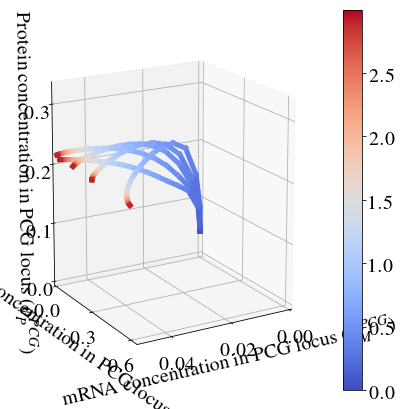

In [69]:
%matplotlib inline

# k_l_list = [0.0002, 0.001, 0.002, 0.003, 0.005, 0.01, 0.015, 0.02, 0.025]
k_l_list = [0.001, 0.005, 0.01, 0.015, 0.025]
target_directory_list = ['/nfs/arupclab001/npradeep96/PhaseField/ACTIVE_MRNA_LNCRNA/MODIFIED_FH_NO_PHIP_COUPLING_VARY_kp_kl/']
name_pattern_list = ["phi_p0_0.04_k_p_lncRNA_{p}_.*_k_p_0.01_.*_Mmrna_0.1_.*_c_max_0.2_phi_r_00.0$"]


D_protein = 100
R = 15.0
phi_p = 0.04
k_degradation = 0.02

fig, axs = plt.subplots(1, 1, figsize=(7,7))

trajectories_p = get_list_of_trajectories(param_list=k_l_list,
                                            target_directory_list=target_directory_list,
                                            name_pattern_list=name_pattern_list,
                                            variable_name='protein_in_SE')
trajectories_l = get_list_of_trajectories(param_list=k_l_list,
                                            target_directory_list=target_directory_list,
                                            name_pattern_list=name_pattern_list,
                                            variable_name='lncrna_in_SE')
trajectories_m = get_list_of_trajectories(param_list=k_l_list,
                                            target_directory_list=target_directory_list,
                                            name_pattern_list=name_pattern_list,
                                            variable_name='erna_in_SE')

axs=plt.axes(projection="3d")

for i in range(len(k_l_list)):
    z = trajectories_p[0][k_l_list[i]]['protein_in_SE']
    x = trajectories_m[0][k_l_list[i]]['erna_in_SE'] 
    y = trajectories_l[0][k_l_list[i]]['lncrna_in_SE']
    color_vals = np.linspace(0.0,1.0,len(x))
    cmap = plt.get_cmap('coolwarm')
    time = trajectories_p[0][k_l_list[i]]['t']*k_degradation
    for j in range(len(x)-1):
        axs.plot(x[j:j+2], y[j:j+2], z[j:j+2], color=cmap(color_vals[j]), linewidth=5.0)

fig.colorbar(line, ax=axs)
axs.set_zlabel('Protein concentration in PCG locus ($\phi^{PCG}_P$)', fontsize=20)
axs.set_xlabel('mRNA concentration in PCG locus ($\phi^{PCG}_M$)', fontsize=20)
axs.set_ylabel('lncRNA concentration in PCG locus ($\phi^{PCG}_R$)', fontsize=20)
axs.view_init(15, 60)
axs.xaxis.set_ticks(np.arange(0.0, 0.05, 0.02))
axs.yaxis.set_ticks(np.arange(0.0, 0.63, 0.3))
axs.zaxis.set_ticks(np.arange(0.0, 0.33, 0.1))
axs.set_ylim([0,0.63])
axs.set_xlim([0,0.05])
axs.set_zlim([0,0.33])
plt.savefig('20220223 - Figures for paper/3d_trajectory.svg', format='svg', dpi=600)

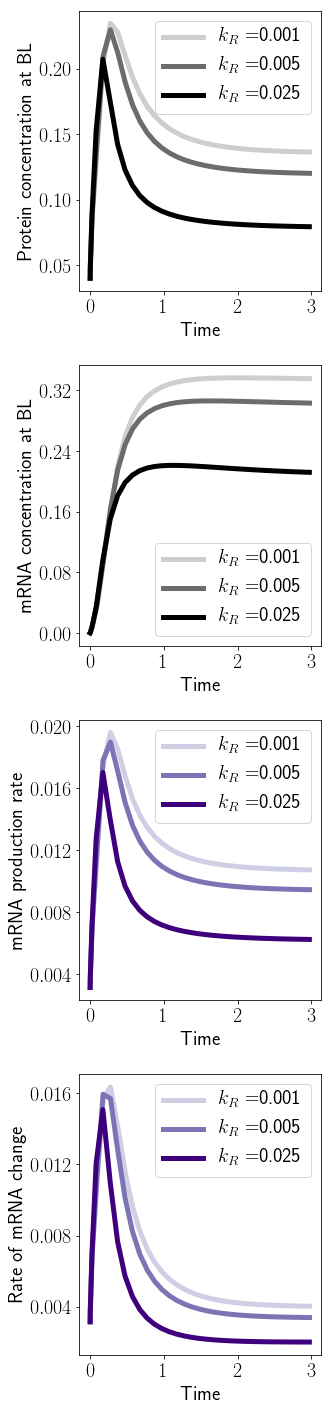

In [103]:
k_l_list = [0.001, 0.005, 0.025] 
# k_l_list = [0.005, 0.01, 0.025] 
k_degradation = 0.02

target_directory_list = ['/nfs/arupclab001/npradeep96/PhaseField/ACTIVE_MRNA_LNCRNA/MODIFIED_FH_NO_PHIP_COUPLING_VARY_kp_kl/']
name_pattern_list = ["phi_p0_0.04_k_p_lncRNA_{p}_.*_k_p_0.1_.*_Mmrna_0.1_.*_c_max_0.2_phi_r_00.0$"]

# variable_names = ['fold_protein_in_SE', 'fold_erna_in_SE', 'condensate_area', 
#                   'fold_avg_eRNA', 'non_dim_avg_eRNA_production_rate', 'non_dim_avg_eRNA_net_rate', 
#                   'non_dim_rate_of_PolII_loading', 'non_dim_cumulative_PolII_loaded']
# ylabels = ['Protein vol. frac. at SE $\phi^{SE}_P/\phi^{avg}_P$',
#            'RNA vol. frac. at SE $\phi^{SE}_R/\phi^c_R$', 'Condensate Area $A/\pi\sigma^2$', 
#            'RNA vol. frac. in system $\phi^{avg}_R/\phi^c_R$', 
#            'RNA production rate $\int k_p(r)\phi_p(r)dV/(k_d\phi^c_R)$',
#            'net rate of RNA $\uparrow ~ 1/(k_d\phi^c_R)\partial \phi^{avg}_R/\partial t$',
#            # 'Rate of Pol II loading $\int Gaussian(r)\phi_p(r)dV$', 
#            'Rate of Pol II loading', 
#            'Total Pol II loaded $1/(\phi^{avg}_PV)\int\int G(r)\phi_p(r)dVdt$']
# cmaps = ['Blues', 'Reds', 'Blues', 'Reds', 'Reds', 'Reds', 'Purples', 'Purples']

variable_names = ['protein_in_SE', 'erna_in_SE', # 'fold_lncrna_in_SE',
                  'avg_eRNA_production_rate', 'avg_eRNA_net_rate']
ylabels = ['Protein concentration at BL', # 'Protein enrichment at SE $\phi^{SE}_P/\phi^{avg}_P$',
           'mRNA concentration at BL', # '$RNA_L$ at SE $\phi^{SE}_{RL}/\phi^c_R$', 
           'mRNA production rate', 'Rate of mRNA change']
cmaps = ['Greys', 'Greys', 'Purples', 'Purples']

N = len(variable_names)

fig, axs = plt.subplots(N,1,figsize=(5,5*N))
color_vals = np.linspace(0.3,1.0,len(k_l_list))

for j in range(len(variable_names)):
    trajectories = get_list_of_trajectories(param_list=k_l_list,
                                            target_directory_list=target_directory_list,
                                            name_pattern_list=name_pattern_list,
                                            variable_name=variable_names[j])
    cmap = plt.get_cmap(cmaps[j])
    for i in range(len(k_l_list)):
        if variable_names[j] == 'fold_protein_in_SE':
            axs[j].plot(k_degradation*trajectories[0][k_l_list[i]]['t'], trajectories[0][k_l_list[i]][variable_names[j]], 
                    '-', c=cmap(color_vals[i]), label="$k_{R}=$"+"{kp}".format(kp=k_l_list[i]),linewidth=5.0)
            # print('hi')
        else: 
            axs[j].plot(k_degradation*trajectories[0][k_l_list[i]]['t'], trajectories[0][k_l_list[i]][variable_names[j]], 
                    '-', c=cmap(color_vals[i]), label="$k_{R}=$"+"{kp}".format(kp=k_l_list[i]),linewidth=5.0)

    axs[j].set_ylabel(ylabels[j])
    axs[j].yaxis.set_major_locator(MaxNLocator(5))
    axs[j].xaxis.set_major_locator(MaxNLocator(4))
    # axs[j].set_xlim([-0.1,5.0])
    axs[j].legend()
    axs[j].set_xlabel('Time')
plt.savefig('20220223 - Figures for paper/dynamics_vs_k_pl_no_protein_coupling_kp_0.1.svg', format='svg', dpi=600)

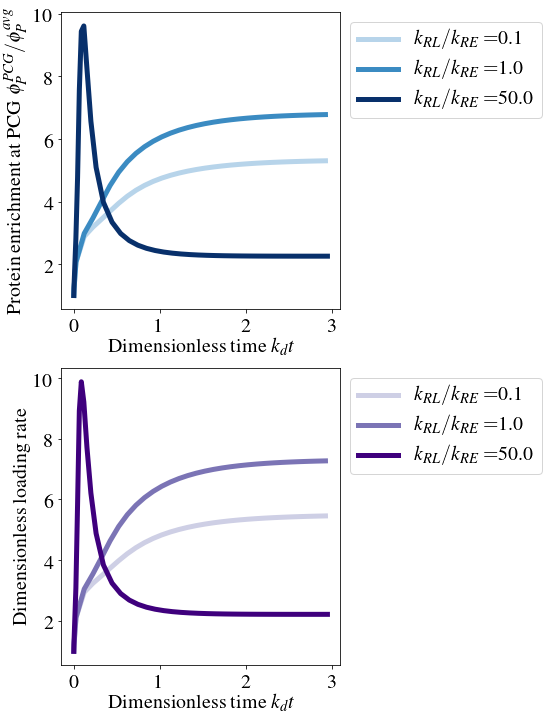

In [22]:
k_l_list = [0.001, 0.01, 0.5]
k_degradation = 0.02

target_directory_list = ['/nfs/arupclab001/npradeep96/PhaseField/ACTIVE_MRNA_LNCRNA/MODIFIED_FH_VARY_kp_kl/']
name_pattern_list = ["phi_p0_0.04_k_p_lncRNA_{p}_.*_k_p_0.01_.*_Mmrna_0.1_.*_c_max_0.2_phi_r_00.0$"]

# variable_names = ['fold_protein_in_SE', 'fold_erna_in_SE', 'condensate_area', 
#                   'fold_avg_eRNA', 'non_dim_avg_eRNA_production_rate', 'non_dim_avg_eRNA_net_rate', 
#                   'non_dim_rate_of_PolII_loading', 'non_dim_cumulative_PolII_loaded']
# ylabels = ['Protein vol. frac. at SE $\phi^{SE}_P/\phi^{avg}_P$',
#            'RNA vol. frac. at SE $\phi^{SE}_R/\phi^c_R$', 'Condensate Area $A/\pi\sigma^2$', 
#            'RNA vol. frac. in system $\phi^{avg}_R/\phi^c_R$', 
#            'RNA production rate $\int k_p(r)\phi_p(r)dV/(k_d\phi^c_R)$',
#            'net rate of RNA $\uparrow ~ 1/(k_d\phi^c_R)\partial \phi^{avg}_R/\partial t$',
#            # 'Rate of Pol II loading $\int Gaussian(r)\phi_p(r)dV$', 
#            'Rate of Pol II loading', 
#            'Total Pol II loaded $1/(\phi^{avg}_PV)\int\int G(r)\phi_p(r)dVdt$']
# cmaps = ['Blues', 'Reds', 'Blues', 'Reds', 'Reds', 'Reds', 'Purples', 'Purples']

variable_names = ['fold_protein_in_SE', 'non_dim_rate_of_PolII_loading']
ylabels = ['Protein enrichment at PCG $\phi^{PCG}_P/\phi^{avg}_P$', 'Dimensionless loading rate']
cmaps = ['Blues', 'Purples']

N = len(variable_names)

fig, axs = plt.subplots(N,1,figsize=(5,6*N))
color_vals = np.linspace(0.3,1.0,len(k_l_list))

for j in range(len(variable_names)):
    trajectories = get_list_of_trajectories(param_list=k_l_list,
                                            target_directory_list=target_directory_list,
                                            name_pattern_list=name_pattern_list,
                                            variable_name=variable_names[j])
    cmap = plt.get_cmap(cmaps[j])
    for i in range(len(k_l_list)):
        axs[j].plot(k_degradation*trajectories[0][k_l_list[i]]['t'], trajectories[0][k_l_list[i]][variable_names[j]], 
                    '-', c=cmap(color_vals[i]), label="$k_{RL}/k_{RE}=$"+"{kp}".format(kp=k_l_list[i]/0.01),linewidth=5.0)

    axs[j].set_ylabel(ylabels[j])
    # axs[j].set_xlim([-0.1,5.0])
    axs[j].legend(bbox_to_anchor=(1, 1), loc='left', ncol=1)
    axs[j].set_xlabel('Dimensionless time $k_dt$')
    
plt.savefig('20220311 - Figures for APS talk/dynamics_vs_k_pl.svg', format='svg', dpi=600)

/home/npradeep96/miniconda3/envs/fipyenv/lib/python2.7/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (108) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/times/utmri8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))


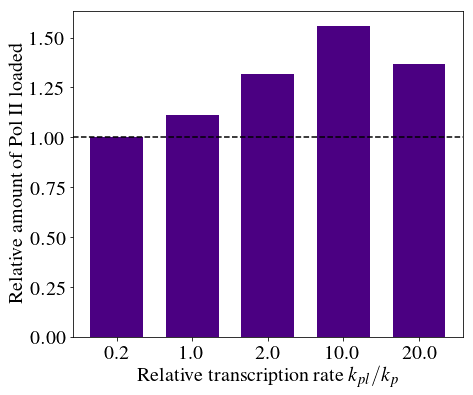

In [223]:
k_l_list = [0.001, 0.005, 0.01, 0.05, 0.1]
labels = ['0.2', '1.0', '2.0', '10.0', '20.0']
variable_name = 'non_dim_cumulative_PolII_loaded'
trajectories = get_list_of_trajectories(param_list=k_l_list,
                                        target_directory_list=target_directory_list,
                                        name_pattern_list=name_pattern_list,
                                        variable_name=variable_name)
ratio = [trajectories[0][k_l_list[i]][variable_name][-1]/trajectories[0][0.001][variable_name][-1] 
         for i in range(len(k_l_list))]

fig, axs = plt.subplots(1,1,figsize=(7,6))
axs.bar(labels, ratio, color='indigo', width=0.7)
axs.set_ylabel('Relative amount of Pol II loaded')
axs.set_xlabel('Relative transcription rate $k_{pl}/k_p$')
axs.axhline(y=1.0, color='k', linestyle='--')
plt.savefig('20220223 - Figures for paper/gene_expression_vs_kp_l.svg', 
            format='svg', dpi=600)

/home/npradeep96/miniconda3/envs/fipyenv/lib/python2.7/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (118) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/times/utmr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/npradeep96/miniconda3/envs/fipyenv/lib/python2.7/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (109) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/times/utmr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/npradeep96/miniconda3/envs/fipyenv/lib/python2.7/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (117) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/times/utmr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/npradeep96/miniconda3/envs/fipyenv/lib/python2.7/site-packages/matplotlib/textpath.py:38

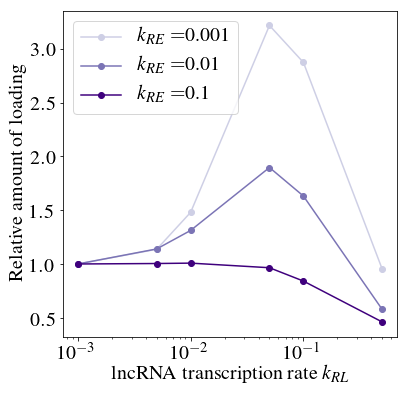

In [18]:
# Plotting the steady state protein recruitment to SE locus

k_l_list = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5]
k_p_list = [0.001, 0.01, 0.1]
target_directory_list = ['/nfs/arupclab001/npradeep96/PhaseField/ACTIVE_MRNA_LNCRNA/MODIFIED_FH_VARY_kp_kl/', 
                         '/nfs/arupclab001/npradeep96/PhaseField/ACTIVE_MRNA_LNCRNA/MODIFIED_FH_VARY_kp_kl/', 
                         '/nfs/arupclab001/npradeep96/PhaseField/ACTIVE_MRNA_LNCRNA/MODIFIED_FH_VARY_kp_kl/']
name_pattern_list = ["phi_p0_0.04_k_p_lncRNA_{p}_.*_k_p_0.001_.*_Mmrna_0.1_.*_c_max_0.2_phi_r_00.0$",
                     "phi_p0_0.04_k_p_lncRNA_{p}_.*_k_p_0.01_.*_Mmrna_0.1_.*_c_max_0.2_phi_r_00.0$",
                     "phi_p0_0.04_k_p_lncRNA_{p}_.*_k_p_0.1_.*_Mmrna_0.1_.*_c_max_0.2_phi_r_00.0$"]
variable_name = 'non_dim_cumulative_PolII_loaded'

trajectories = get_list_of_trajectories(param_list=k_l_list,
                                        target_directory_list=target_directory_list,
                                        name_pattern_list=name_pattern_list,
                                        variable_name=variable_name)
ratios = {}

for j in range(len(k_p_list)):
    ratios[k_p_list[j]] = [trajectories[j][k_l_list[i]][variable_name][-1]/trajectories[j][k_l_list[0]][variable_name][-1] 
                           for i in range(len(k_l_list))]
cmap = plt.get_cmap("Purples")
color_vals = np.linspace(0.3,1.0,len(k_p_list))

fig,axs = plt.subplots(1,1,figsize=(6,6))
for i in range(len(k_p_list)):
    axs.plot(np.array(k_l_list), ratios[k_p_list[i]], '-o', label=r"$k_{RE}=$"+str(k_p_list[i]), c=cmap(color_vals[i]))
axs.set_ylabel('Relative amount of loading')
axs.set_xlabel('lncRNA transcription rate $k_{RL}$')
axs.legend()
axs.set_xscale('log')
plt.savefig('20220311 - Figures for APS talk/gene_expression_vs_k_pl_line.svg', format='svg', dpi=600)

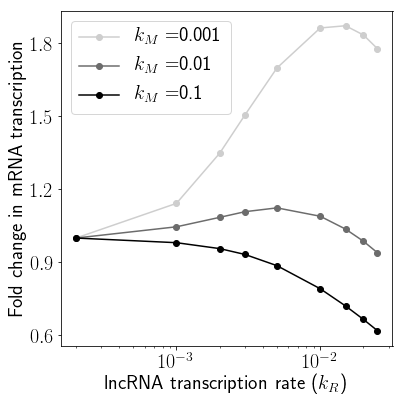

In [104]:
# Plotting the steady state protein recruitment to SE locus

k_l_list = [0.0002, 0.001, 0.002, 0.003, 0.005, 0.01, 0.015, 0.02, 0.025]
k_p_list = [0.001, 0.01, 0.1]
target_directory_list = ['/nfs/arupclab001/npradeep96/PhaseField/ACTIVE_MRNA_LNCRNA/MODIFIED_FH_NO_PHIP_COUPLING_VARY_kp_kl/', 
                         '/nfs/arupclab001/npradeep96/PhaseField/ACTIVE_MRNA_LNCRNA/MODIFIED_FH_NO_PHIP_COUPLING_VARY_kp_kl/', 
                         '/nfs/arupclab001/npradeep96/PhaseField/ACTIVE_MRNA_LNCRNA/MODIFIED_FH_NO_PHIP_COUPLING_VARY_kp_kl/']
name_pattern_list = ["phi_p0_0.04_k_p_lncRNA_{p}_.*_k_p_0.001_.*_Mmrna_0.1_.*_c_max_0.2_phi_r_00.0$",
                     "phi_p0_0.04_k_p_lncRNA_{p}_.*_k_p_0.01_.*_Mmrna_0.1_.*_c_max_0.2_phi_r_00.0$",
                     "phi_p0_0.04_k_p_lncRNA_{p}_.*_k_p_0.1_.*_Mmrna_0.1_.*_c_max_0.2_phi_r_00.0$"]
variable_name = 'fold_erna_in_SE'

trajectories = get_list_of_trajectories(param_list=k_l_list,
                                        target_directory_list=target_directory_list,
                                        name_pattern_list=name_pattern_list,
                                        variable_name=variable_name)
ratios = {}

for j in range(len(k_p_list)):
    ratios[k_p_list[j]] = [trajectories[j][k_l_list[i]][variable_name][-1]/trajectories[j][k_l_list[0]][variable_name][-1] 
                           for i in range(len(k_l_list))]
cmap = plt.get_cmap("Greys")
color_vals = np.linspace(0.3,1.0,len(k_p_list))

fig,axs = plt.subplots(1,1,figsize=(6,6))
for i in range(len(k_p_list)):
    axs.plot(np.array(k_l_list), ratios[k_p_list[i]], '-o', label=r"$k_{M}=$"+str(k_p_list[i]), c=cmap(color_vals[i]))
axs.set_ylabel('Fold change in mRNA transcription')
axs.set_xlabel('lncRNA transcription rate ($k_{R}$)')
axs.yaxis.set_major_locator(MaxNLocator(5))
# axs.xaxis.set_ticks([0.0002, 0.001, 0.005, 0.01, 0.025])
axs.legend()
axs.set_xscale('log')
plt.savefig('20220223 - Figures for paper/gene_expression_vs_k_pl_line.svg', format='svg', dpi=600)

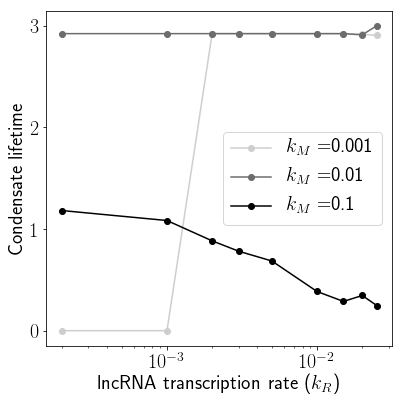

In [105]:
# Plotting the steady state protein recruitment to SE locus

k_l_list = [0.0002, 0.001, 0.002, 0.003, 0.005, 0.01, 0.015, 0.02, 0.025]
k_p_list = [0.001, 0.01, 0.1]
phi_p_thresh = 0.15

target_directory_list = ['/nfs/arupclab001/npradeep96/PhaseField/ACTIVE_MRNA_LNCRNA/MODIFIED_FH_NO_PHIP_COUPLING_VARY_kp_kl/', 
                         '/nfs/arupclab001/npradeep96/PhaseField/ACTIVE_MRNA_LNCRNA/MODIFIED_FH_NO_PHIP_COUPLING_VARY_kp_kl/', 
                         '/nfs/arupclab001/npradeep96/PhaseField/ACTIVE_MRNA_LNCRNA/MODIFIED_FH_NO_PHIP_COUPLING_VARY_kp_kl/']
name_pattern_list = ["phi_p0_0.04_k_p_lncRNA_{p}_.*_k_p_0.001_.*_Mmrna_0.1_.*_c_max_0.2_phi_r_00.0$",
                     "phi_p0_0.04_k_p_lncRNA_{p}_.*_k_p_0.01_.*_Mmrna_0.1_.*_c_max_0.2_phi_r_00.0$",
                     "phi_p0_0.04_k_p_lncRNA_{p}_.*_k_p_0.1_.*_Mmrna_0.1_.*_c_max_0.2_phi_r_00.0$"]
variable_name = 'protein_in_SE'

trajectories = get_list_of_trajectories(param_list=k_l_list,
                                        target_directory_list=target_directory_list,
                                        name_pattern_list=name_pattern_list,
                                        variable_name=variable_name)
times_dict = {}

for j in range(len(k_p_list)):
    times = np.zeros(len(k_l_list))
    for i in range(len(k_l_list)):
        time_range = np.where(trajectories[j][k_l_list[i]][variable_name] > phi_p_thresh)
        # print(trajectories[0][k_p_list[i]]['t'], trajectories[0][k_p_list[i]]['protein_in_SE'])
        if np.any(time_range):
            if np.max(time_range) == np.size(trajectories[j][k_l_list[i]]['t'])-1:
                times[i] = k_degradation*trajectories[j][k_l_list[i]]['t'].iloc[-1]
            else:
                times[i] = k_degradation*trajectories[j][k_l_list[i]]['t'][np.max(time_range)] - k_degradation*trajectories[j][k_l_list[i]]['t'][np.min(time_range)-1]
    times_dict[k_p_list[j]] = times
    
cmap = plt.get_cmap("Greys")
color_vals = np.linspace(0.3,1.0,len(k_p_list))

fig,axs = plt.subplots(1,1,figsize=(6,6))
for i in range(len(k_p_list)):
    axs.plot(np.array(k_l_list), times_dict[k_p_list[i]], '-o', label=r"$k_{M}=$"+str(k_p_list[i]), c=cmap(color_vals[i]))
axs.set_ylabel('Condensate lifetime')
axs.set_xlabel('lncRNA transcription rate ($k_{R}$)')
axs.yaxis.set_major_locator(MaxNLocator(4))
# axs.xaxis.set_ticks([0.0002, 0.001, 0.005, 0.01, 0.025])
axs.legend()
axs.set_xscale('log')
plt.savefig('20220223 - Figures for paper/condensate_lifetime_vs_k_pl_line.svg', format='svg', dpi=600)

In [84]:
print(times)

{0.1: 2.9727086082, 0.01: 2.9985327414}


In [8]:
trajectories = get_list_of_trajectories(param_list=k_p_list,
                                            target_directory_list=target_directory_list,
                                            name_pattern_list=name_pattern_list,
                                            variable_name=variable_names[j])
    for i in range(len(k_p_list)):
        

3

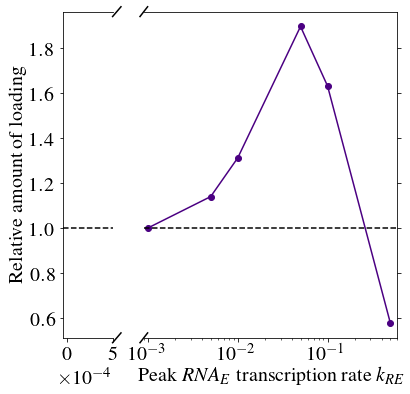

In [333]:
# fig,(ax1,ax2) = plt.subplots(1,2,sharey=True,figsize=(6,6), gridspec_kw={'width_ratios': [1, 5]})
# ax1.plot(k_l_list, ratio, '-o', c='indigo')
# ax2.plot(k_l_list, ratio, '-o', c='indigo')

# ax1.set_xlim([-5e-5,5e-4])
# ax2.set_xlim([9e-4,0.6])

# ax1.spines['right'].set_visible(False)
# ax2.spines['left'].set_visible(False)
# ax1.yaxis.tick_left()
# ax1.tick_params(labelright='off')
# ax2.yaxis.tick_right()

# ax1.set_ylabel('Relative amount of loading')
# ax2.set_xlabel('Peak $RNA_E$ transcription rate $k_{RE}$')
# ax1.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
# ax2.set_xscale('log')

# d = .015 # how big to make the diagonal lines in axes coordinates
# # arguments to pass plot, just so we don't keep repeating them
# kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
# ax1.plot((1-d,1+10*d), (-d,+d), **kwargs)
# ax1.plot((1-d,1+10*d),(1-d,1+d), **kwargs)

# kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
# ax2.plot((-d,+d), (1-d,1+d), **kwargs)
# ax2.plot((-d,+d), (-d,+d), **kwargs)

# ax1.axhline(y=1.0, color='k', linestyle='--')
# ax2.axhline(y=1.0, color='k', linestyle='--')

# plt.savefig('20220223 - Figures for paper/gene_expression_vs_k_pl_line.svg', format='svg', dpi=600)
## plt.savefig('20220223 - Figures for paper/protein_recruitment_to_SE_vs_phi_p_phi_r_pt005.svg', format='svg', dpi=600)

### Phase diagram of gene expression

In [13]:
k_p_list = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5]
k_pl_list = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5]
phi_p = 0.04
sigma = 5.0

target_directory_list = ['/nfs/arupclab001/npradeep96/PhaseField/ACTIVE_MRNA_LNCRNA/MODIFIED_FH_VARY_kp_kl/']*6
name_pattern_list = ["phi_p0_0.04_k_p_lncRNA_{p}_.*"+"_k_p_{kp}_.*_Mmrna_0.1_.*_c_max_0.2_phi_r_00.0$".format(kp=k_p_list[i])
                     for i in range(len(k_p_list))]

variable_name = 'non_dim_cumulative_PolII_loaded'
trajectories = get_list_of_trajectories(param_list=k_pl_list,  
                                        target_directory_list=target_directory_list, 
                                        name_pattern_list=name_pattern_list,  
                                        variable_name=variable_name)

/home/npradeep96/miniconda3/envs/fipyenv/lib/python2.7/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (82) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/times/utmr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/npradeep96/miniconda3/envs/fipyenv/lib/python2.7/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (78) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/times/utmr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/npradeep96/miniconda3/envs/fipyenv/lib/python2.7/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (65) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/times/utmr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/npradeep96/miniconda3/envs/fipyenv/lib/python2.7/site-packages/matplotlib/textpath.py:389: 

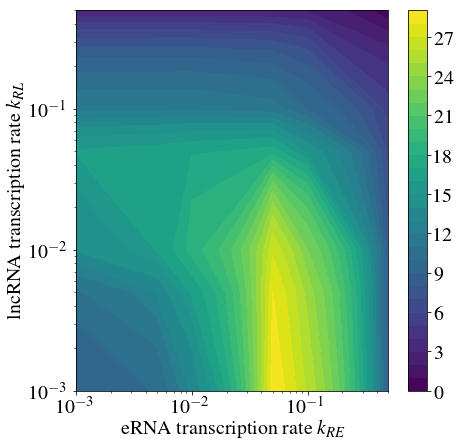

In [15]:
### Phase diagram for gene expression

gene_expression = np.zeros([len(k_p_list), len(k_pl_list)])

for i in range(len(k_p_list)):
    for j in range(len(k_pl_list)):
        gene_expression[i,j] = trajectories[j][k_p_list[i]]['non_dim_cumulative_PolII_loaded'][-1] 

k_p, k_pl = np.meshgrid(k_p_list, k_pl_list)
fig,axs = plt.subplots(1,1,figsize=(7,7))

contour = axs.contourf(k_p, k_pl, gene_expression.transpose(), levels=30)
cbar = fig.colorbar(contour)
cbar.set_clim()
axs.set_xlabel(r'eRNA transcription rate $k_{RE}$')
axs.set_ylabel(r'lncRNA transcription rate $k_{RL}$')
axs.set_yscale('log')
axs.set_xscale('log')
#axs.yaxis.set_minor_formatter(ticker.FormatStrFormatter('%0.3f'))
# axs.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.3f'))
# plt.savefig('20220223 - Figures for paper/gene_expression_phase_diagram.svg', format='svg', dpi=600)
plt.savefig('20220311 - Figures for APS talk/gene_expression_phase_diagram.svg', format='svg', dpi=600)
# axs.set_xlim([0.06,0.22])
# axs.set_ylim([0,0.25])

In [54]:
k_l_list = [0.0002, 0.001, 0.002, 0.003, 0.005, 0.01, 0.015, 0.02, 0.025]
k_p_list = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5]
phi_p = 0.04
sigma = 5.0

target_directory_list = ['/nfs/arupclab001/npradeep96/PhaseField/ACTIVE_MRNA_LNCRNA/MODIFIED_FH_NO_PHIP_COUPLING_VARY_kp_kl/']*6
name_pattern_list = ["phi_p0_0.04_k_p_lncRNA_{p}_.*"+"_k_p_{kp}_.*_Mmrna_0.1_.*_c_max_0.2_phi_r_00.0$".format(kp=k_p_list[i])
                     for i in range(len(k_p_list))]

variable_name = 'fold_erna_in_SE'
trajectories = get_list_of_trajectories(param_list=k_l_list,  
                                        target_directory_list=target_directory_list, 
                                        name_pattern_list=name_pattern_list,  
                                        variable_name=variable_name)

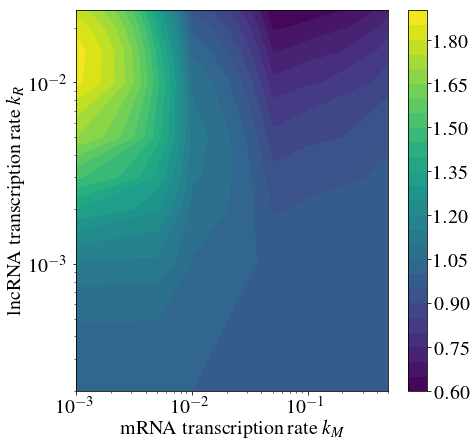

In [60]:
### Phase diagram for gene expression

gene_expression = np.zeros([len(k_p_list), len(k_l_list)])

for i in range(len(k_p_list)):
    for j in range(len(k_l_list)):
        # print(i,j)
        gene_expression[i,j] = trajectories[i][k_l_list[j]]['fold_erna_in_SE'][-1]/trajectories[i][k_l_list[0]]['fold_erna_in_SE'][-1] 

k_p, k_pl = np.meshgrid(k_p_list, k_l_list)
fig,axs = plt.subplots(1,1,figsize=(7,7))

contour = axs.contourf(k_p, k_pl, gene_expression.transpose(), levels=30)
cbar = fig.colorbar(contour)
cbar.set_clim()
axs.set_xlabel(r'mRNA transcription rate $k_{M}$')
axs.set_ylabel(r'lncRNA transcription rate $k_{R}$')
axs.set_yscale('log')
axs.set_xscale('log')
#axs.yaxis.set_minor_formatter(ticker.FormatStrFormatter('%0.3f'))
# axs.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.3f'))
# plt.savefig('20220223 - Figures for paper/gene_expression_phase_diagram.svg', format='svg', dpi=600)
plt.savefig('20220311 - Figures for APS talk/gene_expression_phase_diagram.svg', format='svg', dpi=600)
# axs.set_xlim([0.06,0.22])
# axs.set_ylim([0,0.25])

In [57]:
print(trajectories[5][0.01]['fold_erna_in_SE'][-1])

2.437047


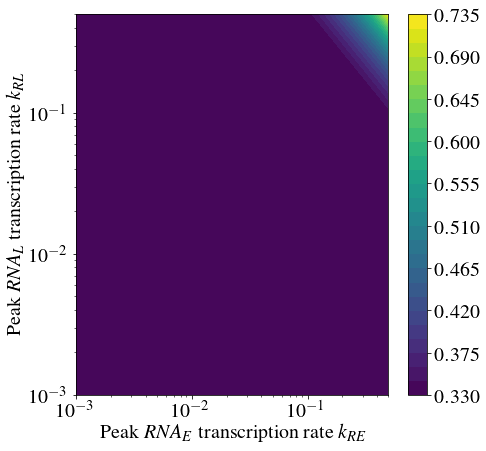

In [340]:
### Phase diagram for time to peak

peak_time = np.zeros([len(k_p_list), len(k_pl_list)])
k_degradation = 0.02

for i in range(len(k_p_list)):
    for j in range(len(k_pl_list)):
        traj = trajectories[j][k_p_list[i]]['non_dim_cumulative_PolII_loaded']
        peak_time[i,j] = k_degradation*trajectories[j][k_p_list[i]]['t'][traj.argmax()]

k_p, k_pl = np.meshgrid(k_p_list, k_pl_list)
fig,axs = plt.subplots(1,1,figsize=(7,7))

contour = axs.contourf(k_p, k_pl, 1/peak_time.transpose(), levels=30)
cbar = fig.colorbar(contour)
cbar.set_clim()
axs.set_xlabel(r'Peak $RNA_E$ transcription rate $k_{RE}$')
axs.set_ylabel(r'Peak $RNA_L$ transcription rate $k_{RL}$')
axs.set_yscale('log')
axs.set_xscale('log')
#axs.yaxis.set_minor_formatter(ticker.FormatStrFormatter('%0.3f'))
# axs.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.3f'))
plt.savefig('20220223 - Figures for paper/times_scale_phase_diagram.svg', format='svg', dpi=600)
# axs.set_xlim([0.06,0.22])
# axs.set_ylim([0,0.25])